In [1]:
# %%capture
# pip install Cython

In [2]:
# %%capture
# pip install PyChest

In [23]:
%%capture
pip install bipartitepandas

In [24]:
%%capture
pip install pytwoway # use Python 3.10.12 if you can't install it.

In [25]:
%%capture
pip install ruptures

In [26]:
# import simbipartiteTest as simTest
import matplotlib.pyplot as plt
import matplotlib.gridspec # To plot clustermap and heatmap side by side
import seaborn as sns
# import CostVisitSimTest as CostSim
import pandas as pd
import pytwoway as tw
import bipartitepandas as bpd
import numpy as np
# import PyChest
import ruptures as rpt
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
# import scipy
import time
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
# Ignore warnings below
simplefilter("ignore", category=ConvergenceWarning) # Useful for logistic regression
pd.options.mode.chained_assignment = None  # default='warn' # Remove copy on slice warning

In [2]:
def temporal_simulation(nb_of_periods,
                           n_patients,
                           n_doctors,
                           z=np.sqrt(2),
                           type_distance='default',
                           alpha_law_graph=(0, 0.5),
                           psi_law_graph=(0, 0.5),
                           alpha_law_cost=(0, 0.5),
                           psi_law_cost=(0, 0.5),
                           preconditioner = 'ichol',
                           beta_age_p_graph=0.01,
                           beta_age_d_graph=0.01,
                           beta_sex_p_graph=0.5,
                           beta_sex_d_graph=0.5,
                           beta_distance_graph=0.5,
                           beta_age_p_cost=0.5,
                           beta_age_d_cost=0.5,
                           beta_sex_p_cost=0.5,
                           beta_sex_d_cost=0.5,
                           beta_distance_cost=0.5):
    """
    Giving parameters, generate data using graph model and cost model and then estimate fixed effects. Returns the sequence of generated dataframes, and the estimations.
    """
    # We set up the parameters to estimate the FE.

    if type_distance not in ['REG', 'DEP', 'CODGEO', 'default']:
        raise Exception("type_distance must be 'REG', 'DEP', 'CODGEO' or 'default'")
    
    if preconditioner not in ['ichol', 'jacobi']:
        raise Exception("preconditioner has to be 'ichol' or 'jacobi'. Prefer 'jacobi' for large datasets.")
        
    
    fecontrol_params = tw.fecontrol_params(
    {
        'ho': True,
        'he': False,
        'feonly': True,
        'continuous_controls': ['distance', 'age_d', 'age_p'],
        'categorical_controls': ['sex_p', 'sex_d'],
        'attach_fe_estimates': True,
        'ncore': 8,
        'preconditioner': preconditioner # It looks like it gives better results (especially for large datasets ?)
    }
    )

    clean_params = bpd.clean_params(
    {
        'connectedness': 'leave_out_spell',
        'collapse_at_connectedness_measure': True,
        'drop_single_stayers': True,
        'drop_returns': 'returners',
        'copy': False
    }
    )

    rng = np.random.default_rng(None)
    alpha_graph = []
    psi_graph = []
    alpha_cost = {} # These are dicts to use the function map later
    psi_cost = {}
    changepoint_patient = np.zeros(n_patients)
    changepoint_doctor = np.zeros(n_doctors + 1)
    coor_patients = []
    coor_doctors = []
    D = np.zeros([n_patients, n_doctors + 1], dtype = np.ndarray)
    log = LogisticRegression()

    for i in range(n_patients):
        
        # We generate the FE for the graph formation model
        alpha_graph.append( np.random.uniform(alpha_law_graph[0], alpha_law_graph[1]) )
        
        # We generate the FE for the cost model
        alpha_cost[i] = np.random.uniform(alpha_law_cost[0], alpha_law_cost[1])

        # We generate the periods when there's a changepoint for each patient
        changepoint_patient[i] = np.random.randint(0, nb_of_periods)

        # Generate the coordinates of the patients
        coor_patients.append( np.random.uniform(0, 1, 2) )
                               
    for j in range(n_doctors + 1):

        # We generate the FE for the graph formation model
        psi_graph.append( np.random.uniform(psi_law_graph[0], psi_law_graph[1]) )

        # We generate the FE for the cost model
        psi_cost[j] = np.random.uniform(psi_law_cost[0], psi_law_cost[1])

        # We generate the periods when there's a changepoint for each doctor
        changepoint_doctor[j] = np.random.randint(0, nb_of_periods)
        
        if j != 0:
            
            # Generate the coordinates of the doctors
            coor_doctors.append( np.random.uniform(0, 1, 2) )

    # Generate distance matrix
    if type_distance == 'default':
    
        for i in range(n_patients):
            for j in range(0, n_doctors + 1):
                if j == 0: # We associate the indice 0 to the "ghost doctor"
                    D[i][0] = 0
                else: # we take the j-1 index of coor_doctors as we added the ghost doctor, j = 1 corresponds to j = 0 in coord_doctors
                    d = np.sqrt(np.power((coor_patients[i][0] - coor_doctors[j-1][0]), 2) + np.power((coor_patients[i][1] - coor_doctors[j-1][1]), 2))
                    D[i][j] = d

    else:

        # Assign randomly a CODGEO, DEP, or REG to patients and doctors
        dist_matrix = pd.read_csv(type_distance + '.csv')
        
        del dist_matrix[dist_matrix.columns[0]]
        dist_matrix.index = dist_matrix.columns
        for i in range(len(dist_matrix)):
            dist_matrix.iloc[i, i] = 0
        arr = dist_matrix.columns.values
        for i,col in enumerate(arr):
            arr[i] = int(float(arr[i]))
        dist_matrix.columns = arr
        dist_matrix.index = arr

        # Generate code for patient and doctor
        code_patient = []
        code_doctor = []
        for i in range(n_patients):
            random_code = np.random.choice(dist_matrix.columns.values)
            code_patient.append( random_code )
        for j in range(n_doctors + 1):
            random_code = np.random.choice(dist_matrix.columns.values)
            code_doctor.append( random_code )
        for i in range(n_patients):
            for j in range(n_doctors):
                D[i, j + 1] = dist_matrix.loc[code_patient[i], code_doctor[j+1]]
                
        
        


    # Random draws of ages for patients and doctors
    sim_patient_age = rng.integers(low = 1, high = 99, size = n_patients)
    sim_doctor_age = rng.integers(low = 26, high = 99, size = n_doctors + 1)

    # Random draws of genders of patients and doctors
    sim_patient_gender = rng.integers(low = 0, high = 2, size = n_patients)
    sim_doctor_gender = rng.integers(low = 0, high = 2, size = n_doctors + 1)

    # Compile ids
    id_p = np.repeat(range(n_patients), n_doctors + 1)
    id_d = np.tile(range(n_doctors + 1), n_patients)

    # Compile fixed effects
    # alp_data = np.repeat(alpha_cost, n_doctors + 1)
    # psi_data = psi_graph * n_patients

    # Compile observed features
    age_p_data = np.repeat(sim_patient_age, n_doctors + 1)
    age_d_data = np.tile(sim_doctor_age, n_patients)
    sex_p_data = np.repeat(sim_patient_gender, n_doctors + 1)
    sex_d_data = np.tile(sim_doctor_gender, n_patients)
    if type_distance != 'default':
        code_patient_data = np.repeat(code_patient, n_doctors + 1)
        code_doctor_data = np.tile(code_doctor, n_patients)

    estimates = []
                               
    # At each period, determine connections                           
    for t in range(nb_of_periods):
    
        # Generate the identifier matrix A based on the distance
        A = np.zeros([n_patients, n_doctors + 1], dtype = np.ndarray)
        for i in range(0, n_patients):
            for j in range(0, n_doctors + 1):
                if j == 0:
                    A[i][0] = 1
                elif D[i][j] > z: # if patient i and doctor j are too far away, there is no relation
                    continue
                else:
                    T = alpha_graph[i] + psi_graph[j] + beta_age_p_graph * sim_patient_age[i] + beta_age_d_graph * sim_doctor_age[j] + beta_sex_p_graph * sim_patient_gender[i] + beta_sex_d_graph * sim_doctor_gender[j] + beta_distance_graph * D[i][j]
                    p = 1 / (1 + np.exp(-T))
                    A[i][j] = np.random.binomial(1, p)

        # Compile relations between doctors and patients
        relation = A.flatten()

        # Merge all columns into a dataframe
        dataframe = pd.DataFrame(data={'i': id_p, 'j': id_d, 'y' : relation, 'age_p': age_p_data, 'age_d': age_d_data, 
                               'sex_p': sex_p_data, 'sex_d': sex_d_data
                                })
        if type_distance != 'default':
            dataframe['code_patient'] = code_patient_data
            dataframe['code_doctor'] = code_doctor_data

        dataframe['distance'] = D[dataframe['i'], dataframe['j']].astype(float)
            
        # Logistic regression for graph formation

        # Add dummy variables
        e_i = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_patients), dtype=int))
        for col in e_i.columns:
            e_i.rename(columns = {col :f'p_{col}'}, inplace = True)
            
        e_j = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_doctors + 1), dtype=int))
        for col in e_j.columns:
            e_j.rename(columns = {col :f'd_{col}'}, inplace = True)
        
        df = pd.concat([dataframe, e_i, e_j], axis = 1)
        
        for i in range(n_patients):
            indexes = df[df['i'] == i].index
            df[f'p_{i}'][indexes] = [1 for i in range(len(indexes))]
        
        for j in range(n_doctors + 1):
            indexes = df[df['j'] == j].index
            df[f'd_{j}'][indexes] = [1 for i in range(len(indexes))]
        
        y = df['y'].astype(int)
        if type_distance != 'default':
            X = df.drop(['i', 'j', 'y', 'code_patient', 'code_doctor'], axis = 1)
        else:
            X = df.drop(['i', 'j', 'y'], axis = 1)
        
        reg = log.fit(X, y)
        coeffs = reg.coef_[0]

        # drop the rows if there is no relation between patient_i and doctor_j
        dataframe = dataframe.drop(dataframe[dataframe['y'] == 0].index)
        dataframe = dataframe.drop('y', axis = 1)
        dataframe = dataframe.reset_index().drop(['index'], axis = 1)



        # We update the laws (if needed) of the patients/doctors
        list_of_indexes_patient = np.where(changepoint_patient == t)[0]
        list_of_indexes_doctor = np.where(changepoint_doctor == t)[0]
        for index_patient in list_of_indexes_patient: 
            
            alpha_cost[index_patient] = np.random.uniform( np.random.uniform(alpha_law_graph[0] + 5, alpha_law_graph[1] + 5) )
    
        for index_doctor in list_of_indexes_doctor:
            
            psi_cost[index_doctor] = np.random.uniform( np.random.uniform(psi_law_graph[0] + 5, psi_law_graph[1] + 5) )

        dataframe['alpha'] = dataframe['i'].map(alpha_cost).astype(float)
        dataframe['psi'] = dataframe['j'].map(psi_cost).astype(float)

        # Compute the cost
        dataframe['y'] = dataframe['alpha'] + dataframe['psi'] + beta_age_p_cost * dataframe['age_p'] + beta_age_d_cost * dataframe['age_d'] + beta_sex_p_cost * dataframe['sex_p'] + beta_sex_d_cost * dataframe['sex_d'] + beta_distance_cost * dataframe['distance']

        # Change dtype of categorical variables
        dataframe['sex_p'] = dataframe['sex_p'].astype("category")
        dataframe['sex_d'] = dataframe['sex_d'].astype("category")
        
        # We create a BipartiteDataFrame in order to estimate the FE for the cost model
        if type_distance == 'default':
            
            bdf = bpd.BipartiteDataFrame(dataframe.drop(['alpha', 'psi'] , axis = 1),
                                     custom_categorical_dict = {'sex_p': True,
                                                                'sex_d': True},
                                     custom_dtype_dict = {'sex_p': 'categorical',
                                                          'sex_d': 'categorical'},
                                     custom_how_collapse_dict = {'sex_p': 'first',
                                                                 'sex_d': 'first'}) # We transform the dataframe as BipartitePandas dataframe to Estimate the FE.
        else:
            
            bdf = bpd.BipartiteDataFrame(dataframe.drop(['alpha', 'psi', 'code_patient', 'code_doctor'] , axis = 1),
                                     custom_categorical_dict = {'sex_p': True,
                                                                'sex_d': True},
                                     custom_dtype_dict = {'sex_p': 'categorical',
                                                          'sex_d': 'categorical'},
                                     custom_how_collapse_dict = {'sex_p': 'first',
                                                                 'sex_d': 'first'}) # We transform the dataframe as BipartitePandas dataframe to Estimate the FE.

    
        bdf.clean(clean_params)
        fe_estimator = tw.FEControlEstimator(bdf, fecontrol_params)
        print(f"Estimating FE for period {t}")
        fe_estimator.fit()
        d = {}
        d['estimates'] = fe_estimator.gamma_hat_dict # Estimates of the EF, Beta for the cost model
        d['true_value'] = dataframe # True values of the features, the initial dataframe.
        d['graph'] = {}
        d['graph']['coeffs'] = coeffs
        d['graph']['alpha'] = alpha_graph
        d['graph']['psi'] = psi_graph
        estimates.append(d)

    return estimates

def extract(temporal_simulation):
    """
    Giving simulated data, extracts only fixed effect estimations/real values for both graph model and cost model. Extracts also the final generated dataframe with prescription costs.
    temporal_simulation[t]['true_value'] is a DataFrame of data at time t
    temporal_simulation[t]['estimates'] is a dict containing the estimates from FEControlEstimator (pytwoway module) of FE at time t
    We only extract the real doctors (ghost doctor isn't taken)
    """

    
    estimates = {}
    estimates['estimates'] = {}
    estimates['estimates']['cost'] = {}
    estimates['estimates']['graph'] = {}
    estimates['estimates']['cost']['alpha'] = {}
    estimates['estimates']['cost']['psi'] = {}
    estimates['estimates']['graph']['alpha'] = {}
    estimates['estimates']['graph']['psi'] = {}
    estimates['true_value'] = {}
    estimates['true_value']['cost'] = {}
    estimates['true_value']['graph'] = {}
    estimates['true_value']['cost']['alpha'] = {}
    estimates['true_value']['cost']['psi'] = {}
    estimates['true_value']['graph']['alpha'] = {}
    estimates['true_value']['graph']['psi'] = {}
    
    nb_of_periods = len(temporal_simulation)
    n_patients = len(temporal_simulation[0]['estimates']['alpha'])
    n_doctors = len(temporal_simulation[0]['estimates']['psi']) # contient le docteur fantôme car on ne le supprime pas

    for i in range(n_patients):

        estimates['estimates']['cost']['alpha'][i] = []
        estimates['estimates']['graph']['alpha'][i] = []
        estimates['true_value']['cost']['alpha'][i] = []
        estimates['true_value']['graph']['alpha'][i] = []
        
    for j in range(n_doctors - 1):
            
        estimates['estimates']['cost']['psi'][j] = []
        estimates['estimates']['graph']['psi'][j] = []
        estimates['true_value']['cost']['psi'][j] = []
        estimates['true_value']['graph']['psi'][j] = []
    

    for t in range(nb_of_periods):
        df = temporal_simulation[t]['true_value']
        for i in temporal_simulation[t]['true_value']['i'].unique():

            estimates['estimates']['cost']['alpha'][i].append( temporal_simulation[t]['estimates']['alpha'][i] )
            estimates['estimates']['graph']['alpha'][i].append( temporal_simulation[t]['graph']['coeffs'][5 + i] )
            estimates['true_value']['cost']['alpha'][i].append( df[df['i'] == i]['alpha'].iloc[0] )
            estimates['true_value']['graph']['alpha'][i].append( temporal_simulation[t]['graph']['alpha'][i] )


        # for j in np.delete(simulation[t]['true_value']['j'].unique(), np.where(simulation[t]['true_value']['j'].unique() == 0)) :
        for j in range(n_doctors - 1): # We dodge the ghost doctor
    
            estimates['estimates']['cost']['psi'][j].append( temporal_simulation[t]['estimates']['psi'][j+1] )
            estimates['estimates']['graph']['psi'][j].append( temporal_simulation[t]['graph']['coeffs'][5 + n_patients + j + 1] )
            estimates['true_value']['cost']['psi'][j].append( df[df['j'] == j+1]['psi'].iloc[0] )
            estimates['true_value']['graph']['psi'][j].append( temporal_simulation[t]['graph']['psi'][j + 1] )
            

            
    return estimates

def extract_from_csv(temporal_simulation):
    """
    Adapted version of extract for CSV files (useful for all the simulations saved as CSV files).
    """

    
    estimates = {}
    estimates['estimates'] = {}
    estimates['estimates']['cost'] = {}
    estimates['estimates']['graph'] = {}
    estimates['estimates']['cost']['alpha'] = {}
    estimates['estimates']['cost']['psi'] = {}
    estimates['estimates']['graph']['alpha'] = {}
    estimates['estimates']['graph']['psi'] = {}
    estimates['true_value'] = {}
    estimates['true_value']['cost'] = {}
    estimates['true_value']['graph'] = {}
    estimates['true_value']['cost']['alpha'] = {}
    estimates['true_value']['cost']['psi'] = {}
    estimates['true_value']['graph']['alpha'] = {}
    estimates['true_value']['graph']['psi'] = {}
    
    nb_of_periods = len(temporal_simulation)
    n_patients = len(temporal_simulation['estimates'][0]['alpha'])
    n_doctors = len(temporal_simulation['estimates'][0]['psi']) # contient le docteur fantôme car on ne le supprime pas

    for i in range(n_patients):

        estimates['estimates']['cost']['alpha'][i] = []
        estimates['estimates']['graph']['alpha'][i] = []
        estimates['true_value']['cost']['alpha'][i] = []
        estimates['true_value']['graph']['alpha'][i] = []
        
    for j in range(n_doctors - 1):
            
        estimates['estimates']['cost']['psi'][j] = []
        estimates['estimates']['graph']['psi'][j] = []
        estimates['true_value']['cost']['psi'][j] = []
        estimates['true_value']['graph']['psi'][j] = []
    

    for t in range(nb_of_periods):
        df = temporal_simulation['true_value'][t]
        for i in temporal_simulation['true_value'][t]['i'].unique():

            estimates['estimates']['cost']['alpha'][i].append( temporal_simulation['estimates'][t]['alpha'][i] )
            estimates['estimates']['graph']['alpha'][i].append( temporal_simulation['graph'][t]['coeffs'][5 + i] )
            estimates['true_value']['cost']['alpha'][i].append( df[df['i'] == i]['alpha'].iloc[0] )
            estimates['true_value']['graph']['alpha'][i].append( temporal_simulation['graph'][t]['alpha'][i] )


        # for j in np.delete(simulation[t]['true_value']['j'].unique(), np.where(simulation[t]['true_value']['j'].unique() == 0)) :
        for j in range(n_doctors - 1): # We dodge the ghost doctor
    
            estimates['estimates']['cost']['psi'][j].append( temporal_simulation['estimates'][t]['psi'][j+1] )
            estimates['estimates']['graph']['psi'][j].append( temporal_simulation['graph'][t]['coeffs'][5 + n_patients + j + 1] )
            estimates['true_value']['cost']['psi'][j].append( df[df['j'] == j+1]['psi'].iloc[0] )
            estimates['true_value']['graph']['psi'][j].append( temporal_simulation['graph'][t]['psi'][j + 1] )
            

            
    return estimates

def changepoint(estimates, process_count, cost="l2", windows_width = 20):
    """
    Giving a sequence of fixed effect estimations/real values (the output from extract), returns the list of change point estimations/real values.
    All the models are: "l1", "l2", "rbf", "linear", "normal", "ar"
    """
    n_patients = len(estimates['estimates']['cost']['alpha'])
    n_doctors = len(estimates['estimates']['cost']['psi'])
    changepoint_estimates = {}
    changepoint_estimates['estimates'] = {}
    changepoint_estimates['estimates']['alpha'] = {}
    changepoint_estimates['estimates']['psi'] = {}
    changepoint_estimates['true_value'] = {}
    changepoint_estimates['true_value']['alpha'] = {}
    changepoint_estimates['true_value']['psi'] = {}

    # Two best models
    # algo = rpt.Dynp(model=cost) # "l1", "l2", "rbf", "linear", "normal", "ar" 
    algo = rpt.Window(width=windows_width, model=cost)

    # Two worst models
    # algo = rpt.Binseg(model=cost)
    # algo = rpt.BottomUp(model=cost)
    
    for i in range(n_patients):

        patient_true_signal = np.array(estimates['true_value']['cost']['alpha'][i])
        patient_estimates_signal = np.array(estimates['estimates']['cost']['alpha'][i])

        
        changepoint_estimates['true_value']['alpha'][i] = algo.fit_predict(patient_true_signal, n_bkps=process_count - 1)[0]
        changepoint_estimates['estimates']['alpha'][i] = algo.fit_predict(patient_estimates_signal, n_bkps=process_count - 1)[0]

        
    for j in range(n_doctors):

        doctor_true_signal = np.array(estimates['true_value']['cost']['psi'][j])
        doctor_estimates_signal = np.array(estimates['estimates']['cost']['psi'][j]) 
        
        changepoint_estimates['true_value']['psi'][j] = algo.fit_predict(doctor_true_signal, n_bkps=process_count - 1)[0]
        changepoint_estimates['estimates']['psi'][j] = algo.fit_predict(doctor_estimates_signal, n_bkps=process_count - 1)[0]

    
    return changepoint_estimates

def changepoint_accuracy(changepoint_estimates):
    """
    Giving the output from changepoint, returns the accuracy (in percent) of well-detected change points
    """

    accuracy = {}
    accuracy['exact'] = {}
    accuracy['almost'] = {}
    
    n_patients = len(changepoint_estimates['estimates']['alpha'])
    n_doctors = len(changepoint_estimates['estimates']['psi'])
    patient_exact_estimation = 0
    doctor_exact_estimation = 0
    patient_almost_estimation = 0
    doctor_almost_estimation = 0
    
    for i in range(n_patients):
        
        true_value_patient = changepoint_estimates['true_value']['alpha'][i]
        estimates_value_patient = changepoint_estimates['estimates']['alpha'][i]
        
        if estimates_value_patient == true_value_patient: # Accuracy exacte
            patient_exact_estimation += 1
        
        if estimates_value_patient in np.arange( true_value_patient - 5, true_value_patient + 5): # Intervalle de confiance
            patient_almost_estimation += 1
            
    for j in range(n_doctors):

        true_value_doctor = changepoint_estimates['true_value']['psi'][j]
        estimates_value_doctor = changepoint_estimates['estimates']['psi'][j]
        
        if estimates_value_doctor == true_value_doctor: # Accuracy exacte
            doctor_exact_estimation += 1
            
        
        if estimates_value_doctor in np.arange( true_value_doctor - 5, true_value_doctor + 5): # Intervalle de confiance
            doctor_almost_estimation += 1

    accuracy['exact']['patient'] = patient_exact_estimation / n_patients
    accuracy['exact']['doctor'] = doctor_exact_estimation / n_doctors
    accuracy['almost']['patient'] = patient_almost_estimation / n_patients
    accuracy['almost']['doctor'] = doctor_almost_estimation / n_doctors
    
    return accuracy


def rmse(simulation,
         beta_agep_graph=0.01,
         beta_aged_graph=0.01,
         beta_sexp_graph=0.5,
         beta_sexd_graph=0.5,
         beta_dist_graph=-0.5,
         beta_agep_cost=0.01,
         beta_aged_cost=0.01,
         beta_sexp_cost=0.5,
         beta_sexd_cost=0.5,
         beta_dist_cost=0.5,
        ):
    """
    Giving a simulation, returns the mean (over time) of the RMSE of fixed effects/features for both models.
    """
    results = {}
    results['graph'] = {}
    results['graph']['patients'] = []
    results['graph']['doctors'] = []
    results['graph']['beta'] = {}
    results['graph']['beta']['age_p'] = []
    results['graph']['beta']['age_d'] = []
    results['graph']['beta']['sex_p'] = []
    results['graph']['beta']['sex_d'] = []
    results['graph']['beta']['distance'] = []
    results['cost'] = {}
    results['cost']['patients'] = []
    results['cost']['doctors'] = []
    results['cost']['beta'] = {}
    results['cost']['beta']['age_p'] = []
    results['cost']['beta']['age_d'] = []
    results['cost']['beta']['sex_p'] = []
    results['cost']['beta']['sex_d'] = []
    results['cost']['beta']['distance'] = []

    nb_of_periods = len(simulation)
    nb_patients = len(simulation[0]['estimates']['alpha'])
    nb_doctors = len(simulation[0]['estimates']['psi']) # It counts the ghost doctor

    # order_features = "age_p", "age_d", "sex_p", "sex_d", "distance"
    # simulation[t]['estimates']['distance']
    for t in range(nb_of_periods):
        
        s_patients = 0
        s_doctors = 0
        df = simulation[t]['true_value']

        # Compute RMSE for patients at time t
        for p in range(nb_patients):
            
            s_patients += (simulation[t]['estimates']['alpha'][p] - df[df['i'] == p]['alpha'].iloc[0]) ** 2

        # Compute RMSE for doctors at time t
        for d in range(nb_doctors - 1):

            s_doctors += (simulation[t]['estimates']['psi'][d+1] - df[df['j'] == d+1]['psi'].iloc[0]) ** 2

        # Compute RMSE for the betas of the graph formation model
        results['graph']['beta']['age_p'].append( np.sqrt( (simulation[t]['graph']['coeffs'][0] - beta_agep_graph ) ** 2 ) )
        results['graph']['beta']['age_d'].append( np.sqrt( (simulation[t]['graph']['coeffs'][1] - beta_aged_graph ) ** 2 ) )
        results['graph']['beta']['sex_p'].append( np.sqrt( (simulation[t]['graph']['coeffs'][2] - beta_sexp_graph ) ** 2 ) )
        results['graph']['beta']['sex_d'].append( np.sqrt( (simulation[t]['graph']['coeffs'][3] - beta_sexd_graph ) ** 2 ) )
        results['graph']['beta']['distance'].append( np.sqrt( (simulation[t]['graph']['coeffs'][4] - beta_dist_graph ) ** 2 ) )

        #Compute RMSE for the betas of the cost model
        results['cost']['beta']['age_p'].append( np.sqrt( (simulation[t]['estimates']['age_p'] - beta_agep_cost ) ** 2 ) )
        results['cost']['beta']['age_d'].append( np.sqrt( (simulation[t]['estimates']['age_d'] - beta_aged_cost ) ** 2 ) )
        results['cost']['beta']['sex_p'].append( np.sqrt( (simulation[t]['estimates']['sex_p'] - beta_sexp_cost ) ** 2 ) )
        results['cost']['beta']['sex_d'].append( np.sqrt( (simulation[t]['estimates']['sex_d'] - beta_sexd_cost ) ** 2 ) )
        results['cost']['beta']['distance'].append( np.sqrt( (simulation[t]['estimates']['distance'] - beta_dist_cost ) ** 2 ) )

        # Append RMSE of the FE of the graph/cost models    
        results['cost']['patients'].append(np.sqrt(s_patients / nb_patients))
        results['cost']['doctors'].append(np.sqrt(s_doctors / nb_doctors))
        results['graph']['patients'].append ( mean_squared_error(simulation[t]['graph']['alpha'], simulation[t]['graph']['coeffs'][5: 5 + nb_patients], squared=True) )
        results['graph']['doctors'].append ( mean_squared_error(simulation[t]['graph']['psi'][1:], simulation[t]['graph']['coeffs'][5 + nb_patients + 1:], squared=True) ) #We "dodge" the ghost doctor

    mean_rmse_graph_age_p = np.array( results['graph']['beta']['age_p'] ).mean()
    mean_rmse_graph_age_d = np.array( results['graph']['beta']['age_d'] ).mean()
    mean_rmse_graph_sex_p = np.array( results['graph']['beta']['sex_p'] ).mean()
    mean_rmse_graph_sex_d = np.array( results['graph']['beta']['sex_d'] ).mean()
    mean_rmse_graph_distance = np.array( results['graph']['beta']['distance'] ).mean()
    mean_rmse_cost_age_p = np.array( results['cost']['beta']['age_p'] ).mean()
    mean_rmse_cost_age_d = np.array( results['cost']['beta']['age_d'] ).mean()
    mean_rmse_cost_sex_p = np.array( results['cost']['beta']['sex_p'] ).mean()
    mean_rmse_cost_sex_d = np.array( results['cost']['beta']['sex_d'] ).mean()
    mean_rmse_cost_distance = np.array( results['cost']['beta']['distance'] ).mean()

    # For each period t, we have computed the RMSE. So we take the mean of the RMSE based on all periods.
    # FE
    mean_rmse_cost_patients = np.array(results['cost']['patients']).mean()
    mean_rmse_cost_doctors = np.array(results['cost']['doctors']).mean()
    mean_rmse_graph_patients = np.array(results['graph']['patients']).mean()
    mean_rmse_graph_doctors = np.array(results['graph']['doctors']).mean()

    # Betas
    mean_rmse_graph_age_p = np.array( results['graph']['beta']['age_p'] ).mean()
    mean_rmse_graph_age_d = np.array( results['graph']['beta']['age_d'] ).mean()
    mean_rmse_graph_sex_p = np.array( results['graph']['beta']['sex_p'] ).mean()
    mean_rmse_graph_sex_d = np.array( results['graph']['beta']['sex_d'] ).mean()
    mean_rmse_graph_distance = np.array( results['graph']['beta']['distance'] ).mean()
    mean_rmse_cost_age_p = np.array( results['cost']['beta']['age_p'] ).mean()
    mean_rmse_cost_age_d = np.array( results['cost']['beta']['age_d'] ).mean()
    mean_rmse_cost_sex_p = np.array( results['cost']['beta']['sex_p'] ).mean()
    mean_rmse_cost_sex_d = np.array( results['cost']['beta']['sex_d'] ).mean()
    mean_rmse_cost_distance = np.array( results['cost']['beta']['distance'] ).mean()


    # For more clarity, we finally return a dictionary.
    d = {}
    d['cost_patients'] = mean_rmse_cost_patients
    d['cost_doctors'] = mean_rmse_cost_doctors
    d['graph_patients'] = mean_rmse_graph_patients
    d['graph_doctors'] = mean_rmse_graph_doctors
    d['graph_age_p'] = mean_rmse_graph_age_p
    d['graph_age_d'] = mean_rmse_graph_age_d
    d['graph_sex_p'] = mean_rmse_graph_sex_p
    d['graph_sex_d'] = mean_rmse_graph_sex_d
    d['graph_distance'] = mean_rmse_graph_distance
    d['cost_age_p'] = mean_rmse_cost_age_p
    d['cost_age_d'] = mean_rmse_cost_age_d
    d['cost_sex_p'] = mean_rmse_cost_sex_p
    d['cost_sex_d'] = mean_rmse_cost_sex_d
    d['cost_distance'] = mean_rmse_cost_distance
            
    # return [mean_rmse_cost_patients, mean_rmse_cost_doctors, mean_rmse_graph_patients, mean_rmse_graph_doctors]
    return d


def aggreg_rmse(nb_of_simulations,
                nb_periods=200,
                nb_patients=200,
                nb_doctors=200,
                dist=np.sqrt(2),
                beta_agep_graph=0.01,
                beta_aged_graph=0.01,
                beta_sexp_graph=0.5,
                beta_sexd_graph=0.5,
                beta_dist_graph=-0.5,
                beta_agep_cost=0.01,
                beta_aged_cost=0.01,
                beta_sexp_cost=0.5,
                beta_sexd_cost=0.5,
                beta_dist_cost=0.5,
               ):
    """
    Used to make all the simulations about the quality of estimation of the fixed effects/features.
    Given parameters and a number of simulations to execute (to well aggregate the RMSE), compute the RMSE of each simulation to finally aggregate it.
    """
    
    rmse_cost_patients = []
    rmse_cost_doctors = []
    rmse_graph_patients = []
    rmse_graph_doctors = []
    rmse_graph_age_p = []
    rmse_graph_age_d = []
    rmse_graph_sex_p = []
    rmse_graph_sex_d = []
    rmse_graph_distance = []
    rmse_cost_age_p = []
    rmse_cost_age_d = []
    rmse_cost_sex_p = []
    rmse_cost_sex_d = []
    rmse_cost_distance = []
    
    for n in range(nb_of_simulations):

        simulation = temporal_simulation(nb_of_periods=nb_periods,
                                            n_patients=nb_patients,
                                            n_doctors=nb_doctors,
                                            z=dist,
                                            alpha_law_graph=(-1, 0),
                                            psi_law_graph=(-1, 0),
                                            alpha_law_cost=(-1, 0),
                                            psi_law_cost=(-1, 0),
                                            preconditioner = 'ichol',
                                            beta_age_p_graph=beta_agep_graph,
                                            beta_age_d_graph=beta_aged_graph,
                                            beta_sex_p_graph=beta_sexp_graph,
                                            beta_sex_d_graph=beta_sexd_graph,
                                            beta_distance_graph=beta_dist_graph,
                                            beta_age_p_cost=beta_agep_cost,
                                            beta_age_d_cost=beta_aged_cost,
                                            beta_sex_p_cost=beta_sexp_cost,
                                            beta_sex_d_cost=beta_sexd_cost,
                                            beta_distance_cost=beta_dist_cost)
        
        rm = rmse(simulation,
                 beta_agep_graph=beta_agep_graph,
                 beta_aged_graph=beta_aged_graph,
                 beta_sexp_graph=beta_sexp_graph,
                 beta_sexd_graph=beta_sexd_graph,
                 beta_dist_graph=beta_dist_graph,
                 beta_agep_cost=beta_agep_cost,
                 beta_aged_cost=beta_aged_cost,
                 beta_sexp_cost=beta_sexp_cost,
                 beta_sexd_cost=beta_sexd_cost,
                 beta_dist_cost=beta_dist_cost,
                )
        rmse_cost_patients.append( rm['cost_patients'] )
        rmse_cost_doctors.append( rm['cost_doctors'] )
        rmse_graph_patients.append ( rm['graph_patients'] )
        rmse_graph_doctors.append( rm['graph_doctors'] )
        rmse_graph_age_p.append( rm['graph_age_p'] )
        rmse_graph_age_d.append( rm['graph_age_d'] )
        rmse_graph_sex_p.append( rm['graph_sex_p'] )
        rmse_graph_sex_d.append( rm['graph_sex_d'] )
        rmse_graph_distance.append( rm['graph_distance'] )
        rmse_cost_age_p.append( rm['cost_age_p'] )
        rmse_cost_age_d.append( rm['cost_age_d'] )
        rmse_cost_sex_p.append( rm['cost_sex_p'] )
        rmse_cost_sex_d.append( rm['cost_sex_d'] )
        rmse_cost_distance.append( rm['cost_distance'] )

    d = {}
    d['cost_patients'] = rmse_cost_patients
    d['cost_doctors'] = rmse_cost_doctors
    d['graph_patients'] = rmse_graph_patients
    d['graph_doctors'] = rmse_graph_doctors
    d['graph_age_p'] = rmse_graph_age_p
    d['graph_age_d'] = rmse_graph_age_d
    d['graph_sex_p'] = rmse_graph_sex_p
    d['graph_sex_d'] = rmse_graph_sex_d
    d['graph_distance'] = rmse_graph_distance
    d['cost_age_p'] = rmse_cost_age_p
    d['cost_age_d'] = rmse_cost_age_d
    d['cost_sex_p'] = rmse_cost_sex_p
    d['cost_sex_d'] = rmse_cost_sex_d
    d['cost_distance'] = rmse_cost_distance

    # return [rmse_cost_patients, rmse_cost_doctors, rmse_graph_patients, rmse_graph_doctors]
    return d

def graph_formation(n_patients,
                    n_doctors,
                    z=1.4,
                    beta_age_p_graph=0.01,
                    beta_age_d_graph=0.01,
                    beta_sex_p_graph=0.5,
                    beta_sex_d_graph=0.5,
                    beta_distance_graph=-0.5,
                    alpha_law_graph=(-1, 0),
                    psi_law_graph=(-1, 0)
                   ):
    """
    Crates only the graph formation part and returns the associated dataframe (useful to only work on the logistic regression)
    """
    coor_patients = []
    coor_doctors = []
    alpha_graph = []
    psi_graph = []
    rng = np.random.default_rng(None)
    D = np.zeros([n_patients, n_doctors + 1], dtype = np.ndarray)

    for i in range(n_patients):
        
        # We generate the FE for the graph formation model
        alpha_graph.append( np.random.uniform(alpha_law_graph[0], alpha_law_graph[1]) )

        # Generate the coordinates of the patients
        coor_patients.append( np.random.uniform(0, 1, 2) )
                               
    for j in range(n_doctors + 1):

        # We generate the FE for the graph formation model
        psi_graph.append( np.random.uniform(psi_law_graph[0], psi_law_graph[1]) )
        
        if j != 0:
            
            # Generate the coordinates of the doctors
            coor_doctors.append( np.random.uniform(0, 1, 2) )

    # Generate distance matrix
    for i in range(n_patients):
        for j in range(0, n_doctors + 1):
            if j == 0: # We associate the indice 0 to the "ghost doctor"
                D[i][0] = 0
            else: # we take the j-1 index of coor_doctors as we added the ghost doctor, j = 1 corresponds to j = 0 in coord_doctors
                d = np.sqrt(np.power((coor_patients[i][0] - coor_doctors[j-1][0]), 2) + np.power((coor_patients[i][1] - coor_doctors[j-1][1]), 2))
                D[i][j] = d

    # Random draws of ages for patients and doctors
    sim_patient_age = rng.integers(low = 1, high = 99, size = n_patients)
    sim_doctor_age = rng.integers(low = 26, high = 99, size = n_doctors + 1)

    # Random draws of genders of patients and doctors
    sim_patient_gender = rng.integers(low = 0, high = 2, size = n_patients)
    sim_doctor_gender = rng.integers(low = 0, high = 2, size = n_doctors + 1)

    # Compile ids
    id_p = np.repeat(range(n_patients), n_doctors + 1)
    id_d = np.tile(range(n_doctors + 1), n_patients)

    # Compile fixed effects
    # alp_data = np.repeat(alpha_cost, n_doctors + 1)
    # psi_data = psi_graph * n_patients

    # Compile observed features
    age_p_data = np.repeat(sim_patient_age, n_doctors + 1)
    age_d_data = np.tile(sim_doctor_age, n_patients)
    sex_p_data = np.repeat(sim_patient_gender, n_doctors + 1)
    sex_d_data = np.tile(sim_doctor_gender, n_patients)

    estimates = []
                               
    # At each period, determine connections                           
    # for t in range(nb_of_periods):
    
    # Generate the identifier matrix A based on the distance
    A = np.zeros([n_patients, n_doctors + 1], dtype = np.ndarray)
    for i in range(0, n_patients):
        for j in range(0, n_doctors + 1):
            if j == 0:
                A[i][0] = 1
            elif D[i][j] > z: # if patient i and doctor j are too far away, there is no relation
                continue
            else:
                T = alpha_graph[i] + psi_graph[j] + beta_age_p_graph * sim_patient_age[i] + beta_age_d_graph * sim_doctor_age[j] + beta_sex_p_graph * sim_patient_gender[i] + beta_sex_d_graph * sim_doctor_gender[j] + beta_distance_graph * D[i][j]
                p = 1 / (1 + np.exp(-T))
                A[i][j] = np.random.binomial(1, p)

    # Compile relations between doctors and patients
    relation = A.flatten()

    # Merge all columns into a dataframe
    dataframe = pd.DataFrame(data={'i': id_p, 'j': id_d, 'y' : relation, 'age_p': age_p_data, 'age_d': age_d_data, 
                           'sex_p': sex_p_data, 'sex_d': sex_d_data
                            })
    dataframe['distance'] = D[dataframe['i'], dataframe['j']].astype(float)

    dataframe = dataframe.reset_index().drop(['index'], axis = 1)
    return (dataframe, alpha_graph, psi_graph)

In [ ]:
# A z fixe
df1 = pd.read_csv('accuracy patient z0.4 ratio 1.csv')
df2 = pd.read_csv('accuracy patient z0.4 ratio 2.csv')
df3 = pd.read_csv('accuracy patient z0.4 ratio 3.csv')
df4 = pd.read_csv('accuracy patient z0.4 ratio 4.csv')
df5 = pd.read_csv('accuracy patient z0.4 ratio 5.csv')

exact_accuracy_sparse = [ df1['sparse'][0], df2['sparse'][0], df3['sparse'][0], df4['sparse'][0], df5['sparse'][0] ]
almost_accuracy_sparse = [ df1['sparse'][1], df2['sparse'][1], df3['sparse'][1], df4['sparse'][1], df5['sparse'][1] ]

exact_accuracy_mid = [ df1['mid'][0], df2['mid'][0], df3['mid'][0], df4['mid'][0], df5['mid'][0] ]
almost_accuracy_mid = [ df1['mid'][1], df2['mid'][1], df3['mid'][1], df4['mid'][1], df5['mid'][1] ]

exact_accuracy_dense = [ df1['dense'][0], df2['dense'][0], df3['dense'][0], df4['dense'][0], df5['dense'][0] ]
almost_accuracy_dense = [ df1['dense'][1], df2['dense'][1], df3['dense'][1], df4['dense'][1], df5['dense'][1] ]

figure, axis = plt.subplots(2, 3, figsize=(16, 8))
axis[0, 0].plot([1, 2, 3, 4, 5], exact_accuracy_sparse)
axis[0, 1].plot([1, 2, 3, 4, 5], exact_accuracy_mid)
axis[0, 2].plot([1, 2, 3, 4, 5], exact_accuracy_dense)
axis[1, 0].plot([1, 2, 3, 4, 5], almost_accuracy_sparse)
axis[1, 1].plot([1, 2, 3, 4, 5], almost_accuracy_mid)
axis[1, 2].plot([1, 2, 3, 4, 5], almost_accuracy_dense)

axis[0, 1].set_xlabel('ratio patients/docteurs')
axis[0, 0].set_ylabel('exact accuracy')
axis[0, 1].set_title('Accuracy exacte en fonction du ratio')

axis[1, 1].set_xlabel('ratio patients/docteurs')
axis[1, 0].set_ylabel('almost accuracy')
axis[1, 1].set_title("Accuracy 'almost' en fonction du ratio")


axis[0, 0].legend()
axis[0, 1].legend()
axis[0, 2].legend()
axis[1, 0].legend()
axis[1, 1].legend()
axis[1, 2].legend()

plt.suptitle('Accuracy en fonction du ratio (z = 0.4)')

In [ ]:
# A ratio fixe: check plot EF accuracies.ipynb
df1 = pd.read_csv('accuracy patient z0.4 ratio 1.csv')
df2 = pd.read_csv('accuracy patient z0.7 ratio 1.csv')
df3 = pd.read_csv('accuracy patient z1.1 ratio 1.csv')
df4 = pd.read_csv('accuracy patient zsqrt(2) ratio 1.csv')

In [422]:
# simulation_test[0]['graph'] = pd.DataFrame(simulation_test)['graph'][0] équivalence pour remanipuler les csv obtenus
# utiliser extract_from_csv pour les simulations récup au format CSV
# extraction['true_value']['graph']['alpha']
# extraction['true_value']['graph']['psi']
# extraction['true_value']['cost']['alpha']
# extraction['true_value']['cost']['psi']
# extraction['estimates']['graph']['alpha']
# extraction['estimates']['graph']['psi']
# extraction['estimates']['cost']['alpha']
# extraction['estimates']['cost']['psi']

In [401]:
%%capture
start_time_sparse = time.time()
simulation_sparse = temporal_simulation(nb_of_periods=100,
                                      n_patients=200,
                                      n_doctors=200,
                                      z=np.sqrt(2),
                                      alpha_law_graph=(0, 0.5),
                                      psi_law_graph=(0, 0.5),
                                      alpha_law_cost=(0, 0.5),
                                      psi_law_cost=(0, 0.5),
                                      preconditioner = 'ichol',
                                      beta_age_p_graph=0.02,
                                      beta_age_d_graph=0.02,
                                      beta_sex_p_graph=0.001,
                                      beta_sex_d_graph=0.001,
                                      beta_distance_graph=-6,
                                      beta_age_p_cost=0.01,
                                      beta_age_d_cost=0.01,
                                      beta_sex_p_cost=0.5,
                                      beta_sex_d_cost=0.5,
                                      beta_distance_cost=0.5)
end_time_sparse = time.time()
# end_time_sparse - start_time_sparse

In [ ]:
%%capture
start_time_mid = time.time()
simulation_mid = temporal_simulation(nb_of_periods=100,
                                      n_patients=200,
                                      n_doctors=200,
                                      z=np.sqrt(2),
                                      alpha_law_graph=(0, 0.5),
                                      psi_law_graph=(0, 0.5),
                                      alpha_law_cost=(0, 0.5),
                                      psi_law_cost=(0, 0.5),
                                      preconditioner = 'ichol',
                                      beta_age_p_graph=0.01,
                                      beta_age_d_graph=0.01,
                                      beta_sex_p_graph=0.5,
                                      beta_sex_d_graph=0.5,
                                      beta_distance_graph=-0.5,
                                      beta_age_p_cost=0.01,
                                      beta_age_d_cost=0.01,
                                      beta_sex_p_cost=0.5,
                                      beta_sex_d_cost=0.5,
                                     beta_distance_cost=0.5)
end_time_mid = time.time()
# end_time_mid - start_time_mid

In [ ]:
%%capture
start_time_dense = time.time()
simulation_dense = temporal_simulation(nb_of_periods=100,
                                      n_patients=200,
                                      n_doctors=200,
                                      z=np.sqrt(2),
                                      alpha_law_graph=(0, 0.5),
                                      psi_law_graph=(0, 0.5),
                                      alpha_law_cost=(0, 0.5),
                                      psi_law_cost=(0, 0.5),
                                      preconditioner = 'ichol',
                                      beta_age_p_graph=0.035,
                                      beta_age_d_graph=0.035,
                                      beta_sex_p_graph=0.5,
                                      beta_sex_d_graph=0.5,
                                      beta_distance_graph=-0.5,
                                      beta_age_p_cost=0.01,
                                      beta_age_d_cost=0.01,
                                      beta_sex_p_cost=0.5,
                                      beta_sex_d_cost=0.5,
                                     beta_distance_cost=0.5)
end_time_dense = time.time()
# end_time_dense - start_time_dense

In [ ]:
df = pd.DataFrame(simulation_dense)
df.to_csv('simulation_dense_1.csv')
df2 = pd.read_csv('simulation_dense_1.csv')
extraction = extract_from_csv(df2)
chgpt = changepoint(extraction, process_count=2, windows_width=20) # Calcul des changepoints (sur la suite d'EF théorique et la suite d'estimateurs des EF)
changepoint_accuracy(chgpt) # Calcul de la précision


ratio patients/docteurs (z = 0.4),1,2,3,4,5
dense,15.602461,0.831705,0.863420,0.902667,0.762857
average,0.760778,0.822794,0.798465,0.925751,0.863473
sparse,0.734452,0.981311,0.750826,0.746279,1.164545


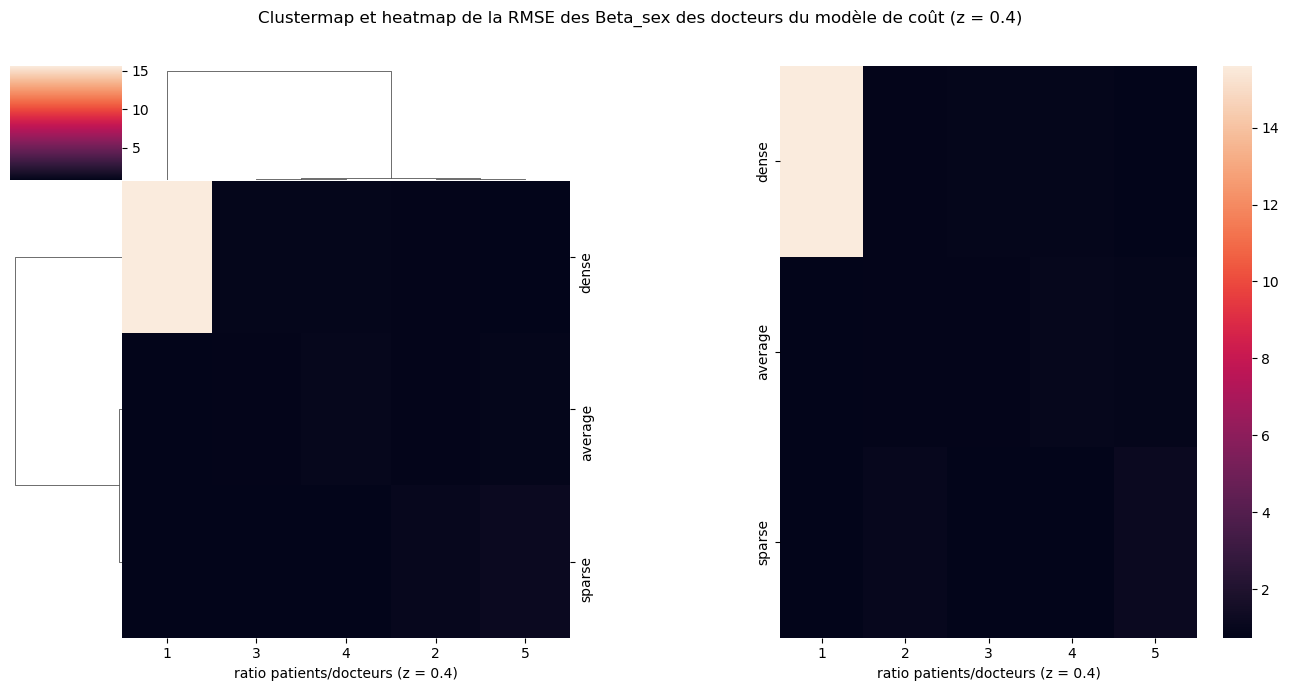

In [389]:
sparse_200 = pd.read_csv('z0.4 200p sparse.csv')['cost_sex_d'].mean()
mid_200 = pd.read_csv('z0.4 200p mid.csv')['cost_sex_d'].mean()
dense_200 = pd.read_csv('z0.4 200p surdense.csv')['cost_sex_d'].mean()

sparse_400 = pd.read_csv('z0.4 400p sparse.csv')['cost_sex_d'].mean()
mid_400 = pd.read_csv('z0.4 400p mid.csv')['cost_sex_d'].mean()
dense_400 = pd.read_csv('z0.4 400p surdense.csv')['cost_sex_d'].mean()

sparse_600 = pd.read_csv('z0.4 600p sparse.csv')['cost_sex_d'].mean()
mid_600 = pd.read_csv('z0.4 600p mid.csv')['cost_sex_d'].mean()
dense_600 = pd.read_csv('z0.4 600p surdense.csv')['cost_sex_d'].mean()

sparse_800 = pd.read_csv('z0.4 800p sparse.csv')['cost_sex_d'].mean()
mid_800 = pd.read_csv('z0.4 800p mid.csv')['cost_sex_d'].mean()
dense_800 = pd.read_csv('z0.4 800p surdense.csv')['cost_sex_d'].mean()

sparse_1000 = pd.read_csv('z0.4 1000p sparse.csv')['cost_sex_d'].mean()
mid_1000 = pd.read_csv('z0.4 1000p mid.csv')['cost_sex_d'].mean()
dense_1000 = pd.read_csv('z0.4 1000p surdense.csv')['cost_sex_d'].mean()

z04_heatmap = pd.DataFrame([[dense_200, dense_400, dense_600, dense_800, dense_1000],
                            [mid_200, mid_400, mid_600, mid_800, mid_1000],
                            [sparse_200, sparse_400, sparse_600, sparse_800, sparse_1000]
                           ])

z04_heatmap = z04_heatmap.rename(index={0: "dense", 1: "average", 2: "sparse"})
z04_heatmap.columns = [1, 2, 3, 4, 5]
z04_heatmap.columns.name = 'ratio patients/docteurs (z = 0.4)'
g = sns.clustermap(z04_heatmap, figsize=(14,7))
g.gs.update(left=0.05, right=0.45) # Reposition the clustermap on the left
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
ax2 = g.fig.add_subplot(gs2[0])
sns.heatmap(z04_heatmap, ax = ax2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Clustermap et heatmap de la RMSE des Beta_sex des docteurs du modèle de coût (z = 0.4)')
z04_heatmap

ratio patients/docteurs (z = 0.7),1,2,3,4,5
dense,0.830878,0.923800,0.943649,0.849323,1.017734
average,0.710857,0.809026,0.912289,1.005668,0.897862
sparse,0.634621,0.743065,0.866562,0.789252,0.973395


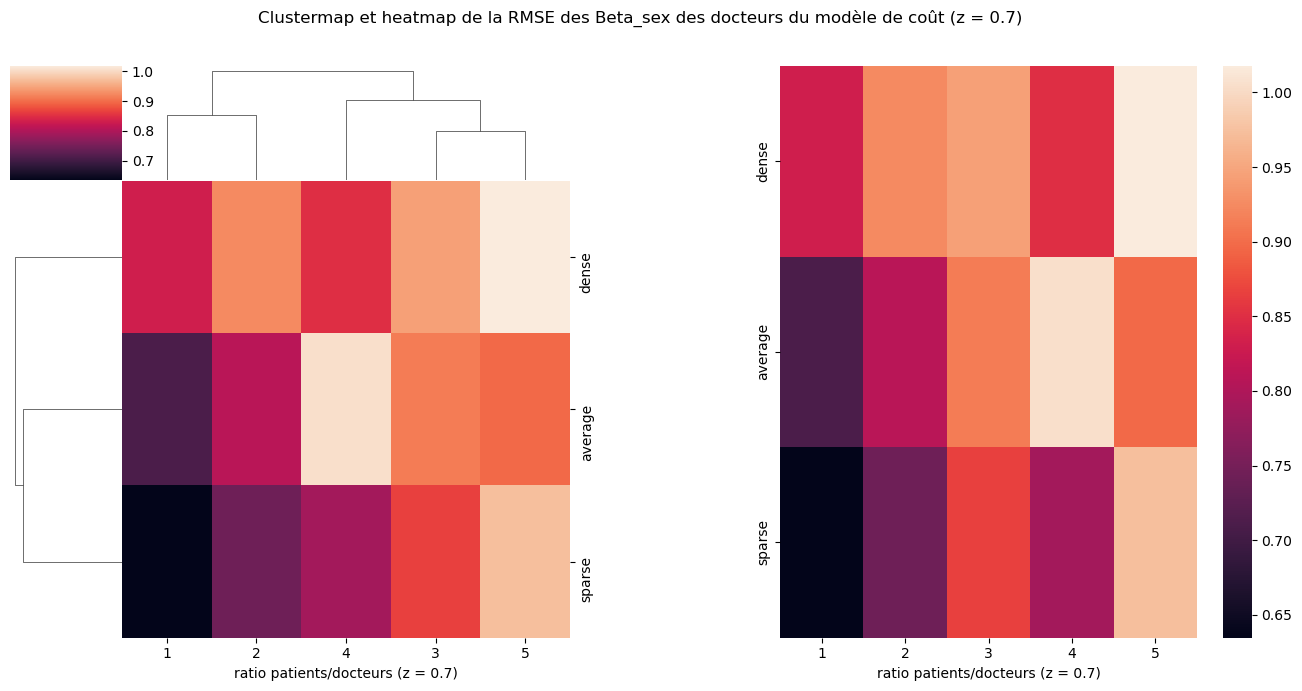

In [390]:
sparse_200 = pd.read_csv('z0.7 200p sparse.csv')['cost_sex_d'].mean()
mid_200 = pd.read_csv('z0.7 200p mid.csv')['cost_sex_d'].mean()
dense_200 = pd.read_csv('z0.7 200p surdense.csv')['cost_sex_d'].mean()

sparse_400 = pd.read_csv('z0.7 400p sparse.csv')['cost_sex_d'].mean()
mid_400 = pd.read_csv('z0.7 400p mid.csv')['cost_sex_d'].mean()
dense_400 = pd.read_csv('z0.7 400p surdense.csv')['cost_sex_d'].mean()

sparse_600 = pd.read_csv('z0.7 600p sparse.csv')['cost_sex_d'].mean()
mid_600 = pd.read_csv('z0.7 600p mid.csv')['cost_sex_d'].mean()
dense_600 = pd.read_csv('z0.7 600p surdense.csv')['cost_sex_d'].mean()

sparse_800 = pd.read_csv('z0.7 800p sparse.csv')['cost_sex_d'].mean()
mid_800 = pd.read_csv('z0.7 800p mid.csv')['cost_sex_d'].mean()
dense_800 = pd.read_csv('z0.7 800p surdense.csv')['cost_sex_d'].mean()

sparse_1000 = pd.read_csv('z0.7 1000p sparse.csv')['cost_sex_d'].mean()
mid_1000 = pd.read_csv('z0.7 1000p mid.csv')['cost_sex_d'].mean()
dense_1000 = pd.read_csv('z0.7 1000p surdense.csv')['cost_sex_d'].mean()

z07_heatmap = pd.DataFrame([[dense_200, dense_400, dense_600, dense_800, dense_1000],
                            [mid_200, mid_400, mid_600, mid_800, mid_1000],
                            [sparse_200, sparse_400, sparse_600, sparse_800, sparse_1000]
                           ])

z07_heatmap = z07_heatmap.rename(index={0: "dense", 1: "average", 2: "sparse"})
z07_heatmap.columns = [1, 2, 3, 4, 5]
z07_heatmap.columns.name = 'ratio patients/docteurs (z = 0.7)'
g = sns.clustermap(z07_heatmap, figsize=(14,7))
g.gs.update(left=0.05, right=0.45) # Reposition the clustermap on the left
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
ax2 = g.fig.add_subplot(gs2[0])
sns.heatmap(z07_heatmap, ax = ax2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Clustermap et heatmap de la RMSE des Beta_sex des docteurs du modèle de coût (z = 0.7)')
z07_heatmap

ratio patients/docteurs (z = 1.1),1,2,3,4,5
dense,2.471110,0.867789,0.964308,0.996796,1.023496
average,0.751272,0.739004,0.858425,0.934629,0.909058
sparse,0.891582,0.737710,0.918923,0.844591,0.943471


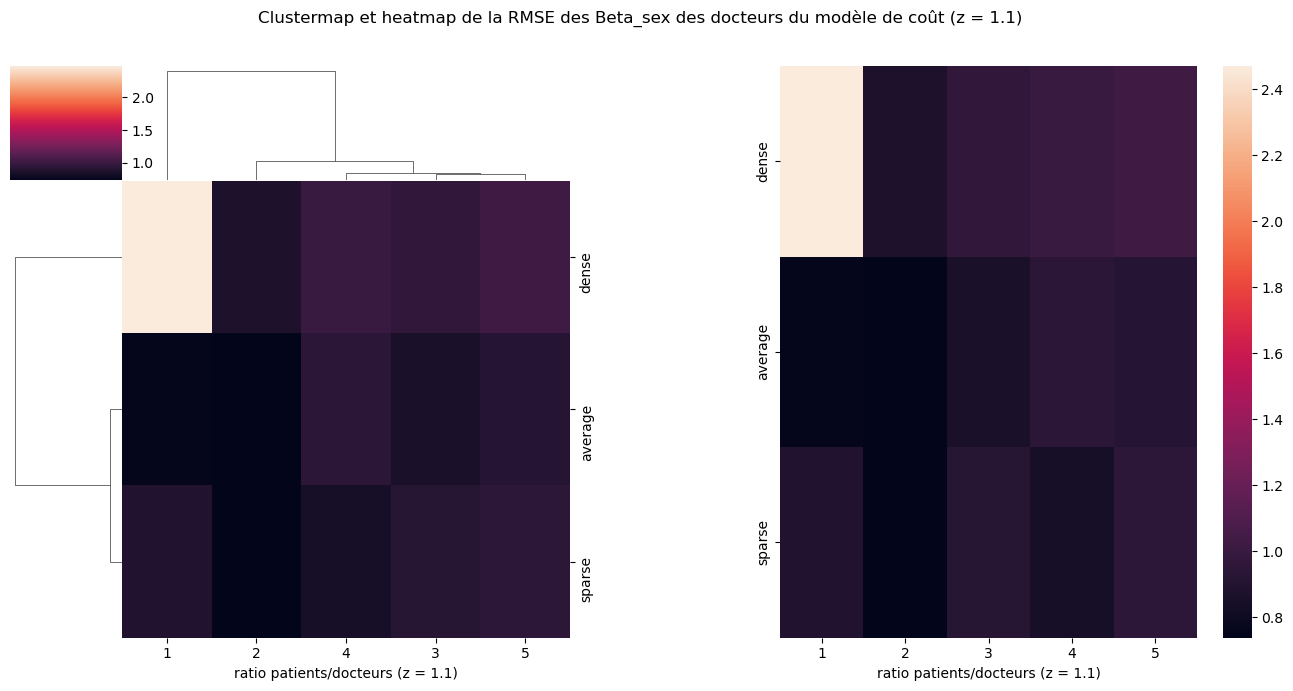

In [391]:
sparse_200 = pd.read_csv('z1.1 200p sparse.csv')['cost_sex_d'].mean()
mid_200 = pd.read_csv('z1.1 200p mid.csv')['cost_sex_d'].mean()
dense_200 = pd.read_csv('z1.1 200p surdense.csv')['cost_sex_d'].mean()

sparse_400 = pd.read_csv('z1.1 400p sparse.csv')['cost_sex_d'].mean()
mid_400 = pd.read_csv('z1.1 400p mid.csv')['cost_sex_d'].mean()
dense_400 = pd.read_csv('z1.1 400p surdense.csv')['cost_sex_d'].mean()

sparse_600 = pd.read_csv('z1.1 600p sparse.csv')['cost_sex_d'].mean()
mid_600 = pd.read_csv('z1.1 600p mid.csv')['cost_sex_d'].mean()
dense_600 = pd.read_csv('z1.1 600p surdense.csv')['cost_sex_d'].mean()

sparse_800 = pd.read_csv('z1.1 800p sparse.csv')['cost_sex_d'].mean()
mid_800 = pd.read_csv('z1.1 800p mid.csv')['cost_sex_d'].mean()
dense_800 = pd.read_csv('z1.1 800p surdense.csv')['cost_sex_d'].mean()

sparse_1000 = pd.read_csv('z1.1 1000p sparse.csv')['cost_sex_d'].mean()
mid_1000 = pd.read_csv('z1.1 1000p mid.csv')['cost_sex_d'].mean()
dense_1000 = pd.read_csv('z1.1 1000p surdense.csv')['cost_sex_d'].mean()

z11_heatmap = pd.DataFrame([[dense_200, dense_400, dense_600, dense_800, dense_1000],
                            [mid_200, mid_400, mid_600, mid_800, mid_1000],
                            [sparse_200, sparse_400, sparse_600, sparse_800, sparse_1000]
                           ])

z11_heatmap = z11_heatmap.rename(index={0: "dense", 1: "average", 2: "sparse"})
z11_heatmap.columns = [1, 2, 3, 4, 5]
z11_heatmap.columns.name = 'ratio patients/docteurs (z = 1.1)'
g = sns.clustermap(z11_heatmap, figsize=(14,7))
g.gs.update(left=0.05, right=0.45) # Reposition the clustermap on the left
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
ax2 = g.fig.add_subplot(gs2[0])
sns.heatmap(z11_heatmap, ax = ax2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Clustermap et heatmap de la RMSE des Beta_sex des docteurs du modèle de coût (z = 1.1)')
z11_heatmap

ratio patients/docteurs (z = sqrt(2)),1,2,3,4,5
dense,2.227941,0.809847,0.914877,0.802946,0.835547
average,0.743393,0.702746,0.802500,0.863277,0.935977
sparse,0.819299,0.784855,0.908806,0.853008,0.896710


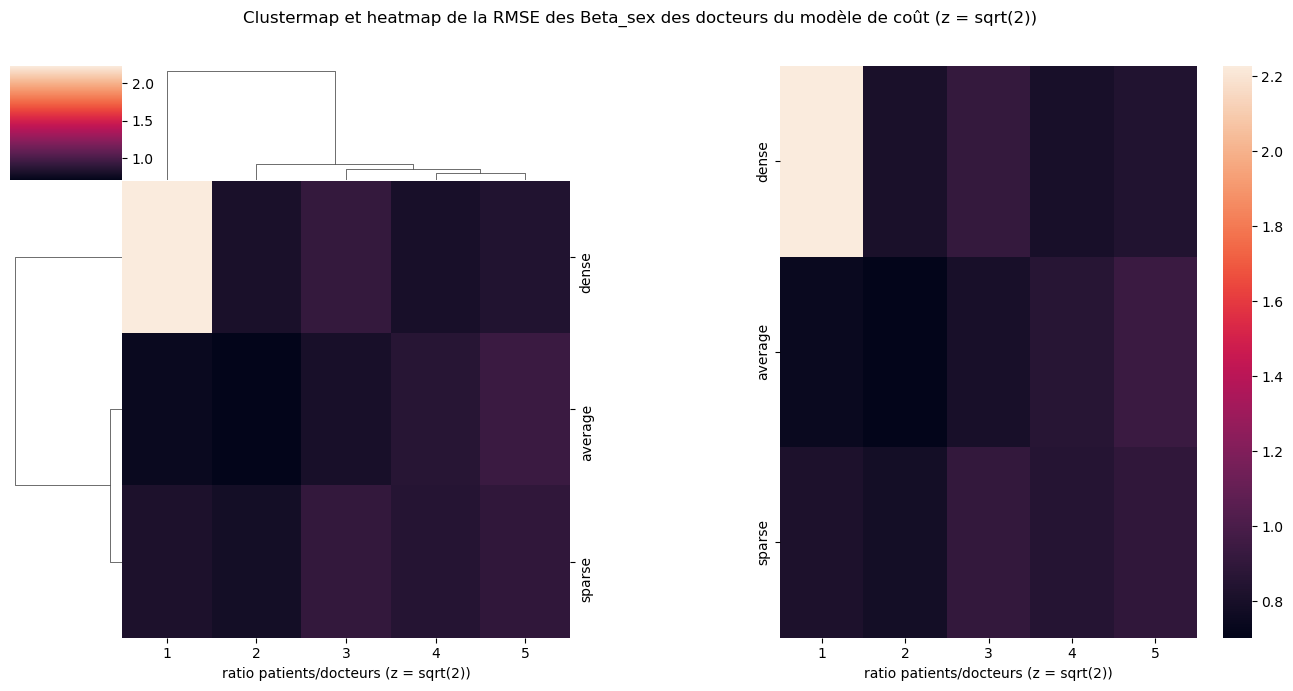

In [392]:
sparse_200 = pd.read_csv('znp.sqrt(2) 200p sparse.csv')['cost_sex_d'].mean()
mid_200 = pd.read_csv('znp.sqrt(2) 200p mid.csv')['cost_sex_d'].mean()
dense_200 = pd.read_csv('znp.sqrt(2) 200p surdense.csv')['cost_sex_d'].mean()

sparse_400 = pd.read_csv('znp.sqrt(2) 400p sparse.csv')['cost_sex_d'].mean()
mid_400 = pd.read_csv('znp.sqrt(2) 400p mid.csv')['cost_sex_d'].mean()
dense_400 = pd.read_csv('znp.sqrt(2) 400p surdense.csv')['cost_sex_d'].mean()

sparse_600 = pd.read_csv('znp.sqrt(2) 600p sparse.csv')['cost_sex_d'].mean()
mid_600 = pd.read_csv('znp.sqrt(2) 600p mid.csv')['cost_sex_d'].mean()
dense_600 = pd.read_csv('znp.sqrt(2) 600p surdense.csv')['cost_sex_d'].mean()

sparse_800 = pd.read_csv('znp.sqrt(2) 800p sparse.csv')['cost_sex_d'].mean()
mid_800 = pd.read_csv('znp.sqrt(2) 800p mid.csv')['cost_sex_d'].mean()
dense_800 = pd.read_csv('znp.sqrt(2) 800p surdense.csv')['cost_sex_d'].mean()

sparse_1000 = pd.read_csv('znp.sqrt(2) 1000p sparse.csv')['cost_sex_d'].mean()
mid_1000 = pd.read_csv('znp.sqrt(2) 1000p mid.csv')['cost_sex_d'].mean()
dense_1000 = pd.read_csv('znp.sqrt(2) 1000p surdense.csv')['cost_sex_d'].mean()

zsqrt_heatmap = pd.DataFrame([[dense_200, dense_400, dense_600, dense_800, dense_1000],
                            [mid_200, mid_400, mid_600, mid_800, mid_1000],
                            [sparse_200, sparse_400, sparse_600, sparse_800, sparse_1000]
                           ])

zsqrt_heatmap = zsqrt_heatmap.rename(index={0: "dense", 1: "average", 2: "sparse"})
zsqrt_heatmap.columns = [1, 2, 3, 4, 5]
zsqrt_heatmap.columns.name = 'ratio patients/docteurs (z = sqrt(2))'
g = sns.clustermap(zsqrt_heatmap, figsize=(14,7))
g.gs.update(left=0.05, right=0.45) # Reposition the clustermap on the left
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
ax2 = g.fig.add_subplot(gs2[0])
sns.heatmap(zsqrt_heatmap, ax = ax2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Clustermap et heatmap de la RMSE des Beta_sex des docteurs du modèle de coût (z = sqrt(2))')
zsqrt_heatmap

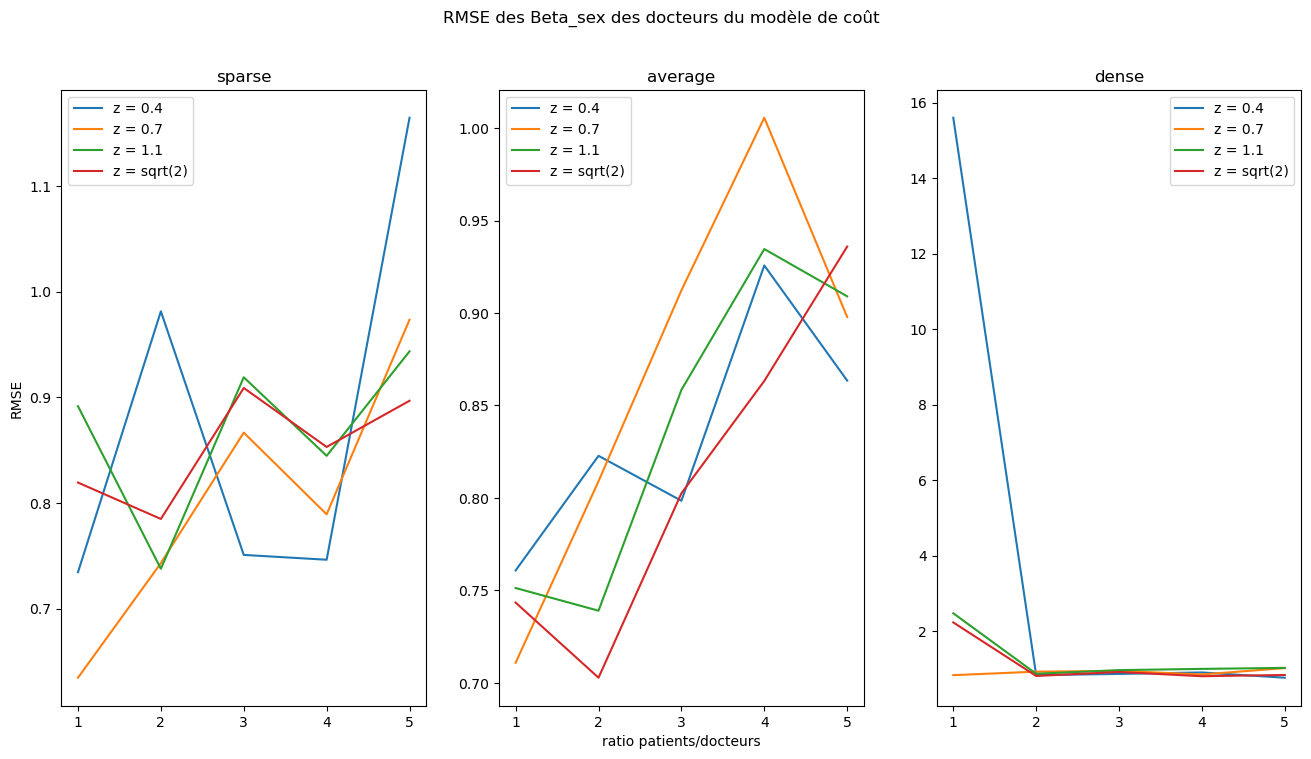

In [393]:
figure, axis = plt.subplots(1, 3, figsize=(16, 8))

axis[0].plot(z04_heatmap.iloc[2], label = 'z = 0.4')
axis[0].plot(z07_heatmap.iloc[2], label = 'z = 0.7')
axis[0].plot(z11_heatmap.iloc[2], label = 'z = 1.1')
axis[0].plot(zsqrt_heatmap.iloc[2], label = 'z = sqrt(2)')

axis[1].plot(z04_heatmap.iloc[1], label = 'z = 0.4')
axis[1].plot(z07_heatmap.iloc[1], label = 'z = 0.7')
axis[1].plot(z11_heatmap.iloc[1], label = 'z = 1.1')
axis[1].plot(zsqrt_heatmap.iloc[1], label = 'z = sqrt(2)')

axis[2].plot(z04_heatmap.iloc[0], label = 'z = 0.4')
axis[2].plot(z07_heatmap.iloc[0], label = 'z = 0.7')
axis[2].plot(z11_heatmap.iloc[0], label = 'z = 1.1')
axis[2].plot(zsqrt_heatmap.iloc[0], label = 'z = sqrt(2)')

axis[1].set_xlabel('ratio patients/docteurs')
axis[0].set_ylabel('RMSE')

axis[0].set_title('sparse')
axis[1].set_title('average')
axis[2].set_title('dense')

axis[0].legend()
axis[1].legend()
axis[2].legend()

plt.suptitle('RMSE des Beta_sex des docteurs du modèle de coût')
plt.show()

In [1087]:
%%capture
start_time = time.time()
simul2 = aggreg_rmse(nb_of_simulations=20,
                nb_periods=200,
                nb_patients=200,
                nb_doctors=200,
                dist=0.4,
                beta_agep_graph=0.01,
                beta_aged_graph=0.01,
                beta_sexp_graph=0.5,
                beta_sexd_graph=0.5,
                beta_dist_graph=-0.5,
                beta_agep_cost=0.01,
                beta_aged_cost=0.01,
                beta_sexp_cost=0.5,
                beta_sexd_cost=0.5,
                beta_dist_cost=0.5,
            )
end_time = time.time()

{'whiskers': [<matplotlib.lines.Line2D at 0x7efb2e6c9930>,
 'caps': [<matplotlib.lines.Line2D at 0x7efb2e6c8e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efb2e9254b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7efb2e6c9570>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efb2ecf2590>],
 'means': []}

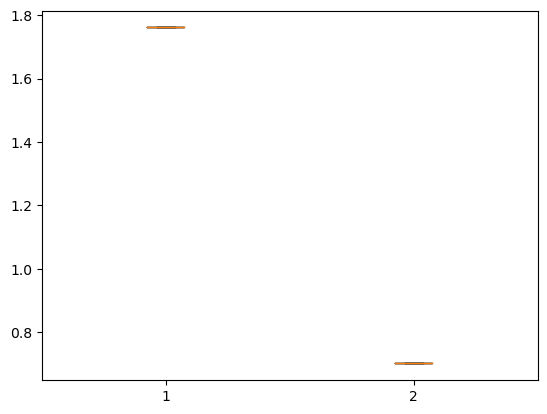

In [1088]:
plt.boxplot(simul2['cost_patients'], positions = [1])
plt.boxplot(simul2['cost_doctors'], positions = [2])

{'whiskers': [<matplotlib.lines.Line2D at 0x7efb2ea959c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efb2ea95360>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efb2ea97610>],
 'medians': [<matplotlib.lines.Line2D at 0x7efb2e3d7e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efb2e3d4d00>],
 'means': []}

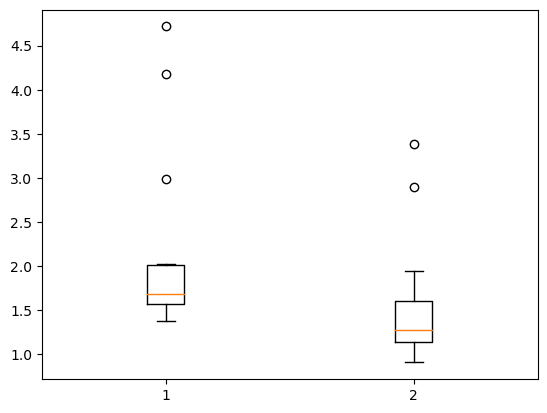

In [1047]:
plt.boxplot(simul['cost_patients'], positions = [1])
plt.boxplot(simul['cost_doctors'], positions = [2])

In [ ]:
# 10 simulations chaque fois, 200 périodes
# On fixe Z = 0.4, 0.7, 1.1, np.sqrt(2)
# On fixe les params de sorte à avoir les =/= taux de connexion, 3 cas

# 200 docteurs/200 patients puis 400/600/800/1000 patients 

In [ ]:
aggreg_rmse(nb_of_simulations=10,
                nb_periods=200,
                nb_patients=200,
                nb_doctors=200,
                dist=0.4,
                beta_agep_graph=0.01,
                beta_aged_graph=0.01,
                beta_sexp_graph=0.5,
                beta_sexd_graph=0.5,
                beta_dist_graph=-0.5,
                beta_agep_cost=0.01,
                beta_aged_cost=0.01,
                beta_sexp_cost=0.5,
                beta_sexd_cost=0.5,
                beta_dist_cost=0.5,
            )

In [9]:
# pour les beta graph
# proba connexion proche de 0.1

beta_1 = 0.02
beta_2 = 0.02
beta_3 = 0.001
beta_4 = 0.001
beta_5 = -6

T1 = -0.2 + -0.2 + beta_1 * 60 + beta_2 * 50 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.3 # cas chanceux
T2 = -0.5 + -0.5 + beta_1 * 40 + beta_2 * 40 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.5 # cas normal
T3 = -1 + -1 + beta_1 * 20 + beta_2 * 30 + beta_3 * 1 + beta_4 * 1 + beta_5 * 1 # cas pas chanceux
1 / (1 + np.exp(-T1)), 1 / (1 + np.exp(-T2)), 1 / (1 + np.exp(-T3))

(0.5004999998333333, 0.08332533368784696, 0.0009128734550938163)

In [7]:
# proba connexion large
beta_1 = 0.01
beta_2 = 0.01
beta_3 = 0.5
beta_4 = 0.5
beta_5 = -0.5

T = -0.4 + -0.3 + beta_1 * 50 + beta_2 * 50 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.5

T1 = -0.8 + -0.8 + beta_1 * 20 + beta_2 * 30 + beta_3 * 1 + beta_4 * 1 + beta_5 * 1
T2 = -0.5 + -0.5 + beta_1 * 40 + beta_2 * 40 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.5
T3 = -0.2 + -0.2 + beta_1 * 60 + beta_2 * 50 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.3
1 / (1 + np.exp(-T1)), 1 / (1 + np.exp(-T2)), 1 / (1 + np.exp(-T3))

(0.35434369377420455, 0.6341355910108007, 0.8249137318359602)

In [6]:
# proba connexion proche de 1
beta_1 = 0.035
beta_2 = 0.035
beta_3 = 0.5
beta_4 = 0.5
beta_5 = -0.5

T = -0.4 + -0.3 + beta_1 * 50 + beta_2 * 50 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.5

T1 = -0.8 + -0.8 + beta_1 * 20 + beta_2 * 30 + beta_3 * 1 + beta_4 * 1 + beta_5 * 1
T2 = -0.5 + -0.5 + beta_1 * 40 + beta_2 * 40 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.5
T3 = -0.2 + -0.2 + beta_1 * 60 + beta_2 * 50 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.3
1 / (1 + np.exp(-T1)), 1 / (1 + np.exp(-T2)), 1 / (1 + np.exp(-T3))

(0.6570104626734988, 0.9275735146384823, 0.9866130821723351)

In [997]:
pd.options.mode.chained_assignment = None  # default='warn' # Remove copy on slice warning
n_patients = 200
n_doctors = 200 # sans compter le docteur fantôme
regg = graph_formation(n_patients, n_doctors, z=0.4)

e_i = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_patients), dtype=int))
# e_i = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_patients)))
for col in e_i.columns:
    e_i.rename(columns = {col :f'p_{col}'}, inplace = True)
    
e_j = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_doctors + 1), dtype=int))
# e_j = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_doctors + 1)))
for col in e_j.columns:
    e_j.rename(columns = {col :f'd_{col}'}, inplace = True)

df = pd.concat([regg[0], e_i, e_j], axis = 1)

for i in range(n_patients):
    indexes = df[df['i'] == i].index
    df[f'p_{i}'][indexes] = [1 for i in range(len(indexes))]

for j in range(n_doctors + 1):
    indexes = df[df['j'] == j].index
    df[f'd_{j}'][indexes] = [1 for i in range(len(indexes))]

y = df['y'].astype(int)
X = df.drop(['i', 'j', 'y'], axis = 1)

# X_to_scale = X[['age_p', 'age_d']]
X_to_scale = X[['distance']]
scaler = preprocessing.StandardScaler().fit(X_to_scale)
X_pscaled = pd.DataFrame(scaler.transform(X_to_scale))
# X_pscaled.columns = ['age_p', 'age_d']
X_pscaled.columns = ['distance']
X_scaled = pd.concat([X_pscaled, X.drop(['distance'], axis=1)], axis = 1)

# scaler = preprocessing.StandardScaler().fit(X)
# X_scaled = scaler.transform(X)

log = LogisticRegression(fit_intercept=True)
reg = log.fit(X_scaled, y)

In [1000]:
reg.coef_[0][0]

-2.773940983253395

In [998]:
X_scaled

,distance,age_p,age_d,sex_p,sex_d,p_0,p_1,p_2,p_3,p_4,...,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200
0,-2.075334,36,64,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.208912,36,88,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.047890,36,54,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.976764,36,80,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.276078,36,48,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40195,0.497687,14,36,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
40196,1.658182,14,30,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
40197,1.041080,14,37,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
40198,1.460825,14,32,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


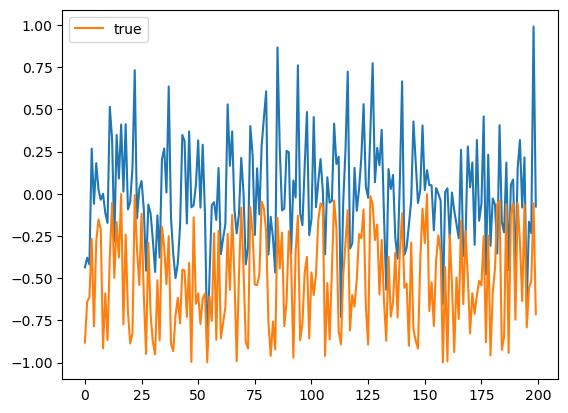

In [956]:
plt.plot(reg.coef_[0][5: 205])
plt.plot(regg[1], label='true')
plt.legend()

# plt.plot(reg.coef_[0][505:])
# plt.plot(regg[2])


In [120]:
# temporal_simulation renvoie une liste indexée par le nombre de périodes, temporal_simulation[t]['estimates'] contenant la sortie de FEControlEstimator (un dictionnaire avec les estimations) et 
# temporal_simulation[t]['true_value'] renvoie le dataframe sur lequel on estime les EF

In [919]:
%%capture
start_time = time.time()
simulation = temporal_simulation(nb_of_periods=300,
                                    n_patients=200,
                                    n_doctors=200,
                                    z=0.4,
                                    alpha_law_graph=(-1, 0),
                                    psi_law_graph=(-1, 0),
                                    alpha_law_cost=(-1, 0),
                                    psi_law_cost=(-1, 0),
                                    preconditioner = 'jacobi',
                                    beta_age_p_graph=0.01,
                                    beta_age_d_graph=0.01,
                                    beta_sex_p_graph=0.5,
                                    beta_sex_d_graph=0.5,
                                    beta_distance_graph=-0.5,
                                    beta_age_p_cost=0.01,
                                    beta_age_d_cost=0.01,
                                    beta_sex_p_cost=0.5,
                                    beta_sex_d_cost=0.5,
                                    beta_distance_cost=0.5)
end_time = time.time()

In [922]:
# 40 minutes pour 300 périodes, 200 patients/docteurs, faible distance !
# go 200 périodes ? 20 simulations ? ou 10 pcq sinon bcp trop long
end_time - start_time

2349.2251286506653

In [916]:
# estimates['estimates'] contient uniquement les estimations des EF
# estimates['true_value'] contient uniquement les vraies valeurs des EF
# estimates permet en particulier de ne récupérer que les EF des vrais docteurs (on ignore le docteur fantôme, et le vecteur de 0 ajouté par pytwoway), pratique pour faire les plots
estimates = extract(simulation)
# estimates = extract_from_csv(simulation)

In [649]:
# "l1", "l2", "ar", "normal"
# l2 looks the more precise
chngpts = changepoint(estimates, process_count=2, cost="l2")
changepoint_accuracy(chngpts)

{'patient': 0.77, 'doctor': 0.9047619047619048}

In [10]:
%%capture
simulation = temporal_simulation(nb_of_periods=100,
                                    n_patients=80,
                                    n_doctors=20,
                                    z=0.4,
                                    alpha_law_graph=(-1, 0),
                                    psi_law_graph=(-1, 0),
                                    alpha_law_cost=(-1, 0),
                                    psi_law_cost=(-1, 0),
                                    preconditioner = 'jacobi',
                                    beta_age_p_graph=0.01,
                                    beta_age_d_graph=0.01,
                                    beta_sex_p_graph=0.5,
                                    beta_sex_d_graph=0.5,
                                    beta_distance_graph=-0.5,
                                    beta_age_p_cost=0.01,
                                    beta_age_d_cost=0.01,
                                    beta_sex_p_cost=0.5,
                                    beta_sex_d_cost=0.5,
                                    beta_distance_cost=0.5)
estimates = extract(simulation)

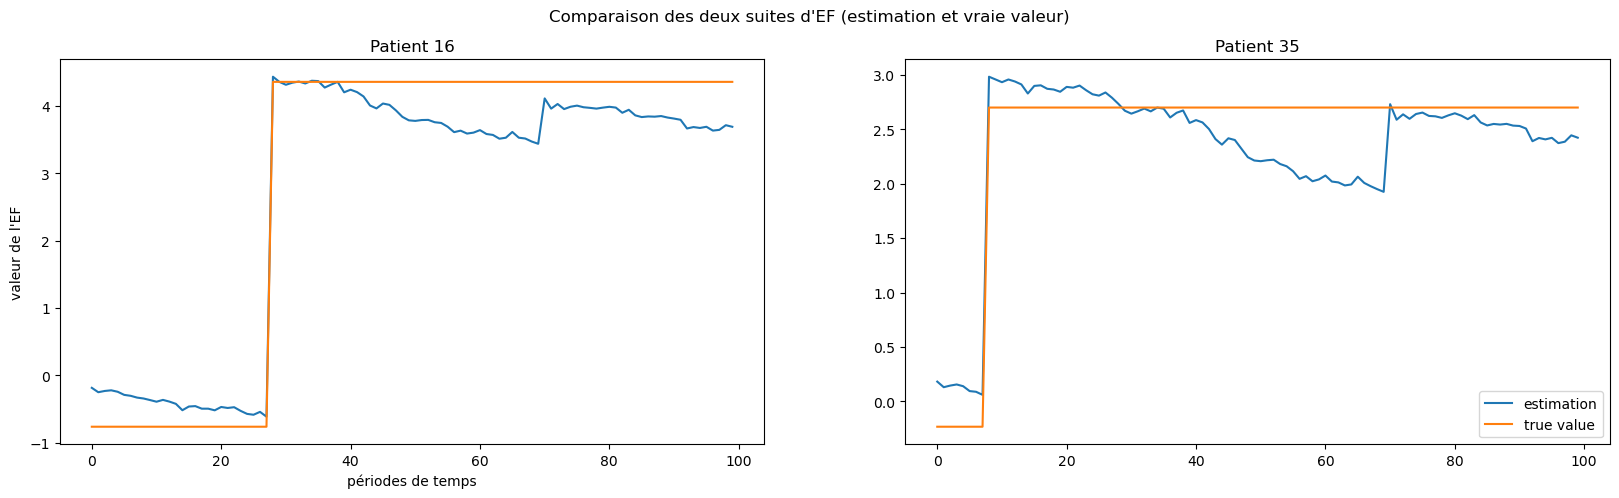

In [15]:
# Utile pour parler de la qualité de l'estimation des changepoints via l'accuracy exacte et presque-exacte (on a mesuré la qualité de l'estimation des EF via la RMSE, maintenant on s'attarde à la qualité
# d'estimation des changepoints en se basant sur la suite d'estimateurs des EF). Parler du fait qu'ici, l'estimation est de qualité, peut-être qu'elle n'est pas toujours aussi qualitative
# (comparer avec plot juste en dessous). La qualité dépend de pas mal de paramètres: la distance max z, le ratio patients/docteurs, les paramètres beta. En fait, tous ces paramètres influencent une chose:
# le nombre de données.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Comparaison des deux suites d'EF (estimation et vraie valeur)")
ax1.plot(estimates['estimates']['cost']['alpha'][16], label = 'estimation')
ax1.plot(estimates['true_value']['cost']['alpha'][16], label = 'true value')
ax1.set_xlabel('périodes de temps')
ax1.set_ylabel("valeur de l'EF")
ax1.title.set_text('Patient 16')
ax2.plot(estimates['estimates']['cost']['alpha'][37], label = 'estimation')
ax2.plot(estimates['true_value']['cost']['alpha'][37], label = 'true value')
ax2.title.set_text('Patient 35')
plt.legend()

In [16]:
%%capture
simulation = temporal_simulation(nb_of_periods=100,
                                    n_patients=80,
                                    n_doctors=20,
                                    z=0.4,
                                    alpha_law_graph=(-1, 0),
                                    psi_law_graph=(-1, 0),
                                    alpha_law_cost=(-1, 0),
                                    psi_law_cost=(-1, 0),
                                    preconditioner = 'jacobi',
                                    beta_age_p_graph=0.02,
                                    beta_age_d_graph=0.02,
                                    beta_sex_p_graph=0.001,
                                    beta_sex_d_graph=0.001,
                                    beta_distance_graph=-6,
                                    beta_age_p_cost=0.01,
                                    beta_age_d_cost=0.01,
                                    beta_sex_p_cost=0.5,
                                    beta_sex_d_cost=0.5,
                                    beta_distance_cost=0.5)
estimates = extract(simulation)

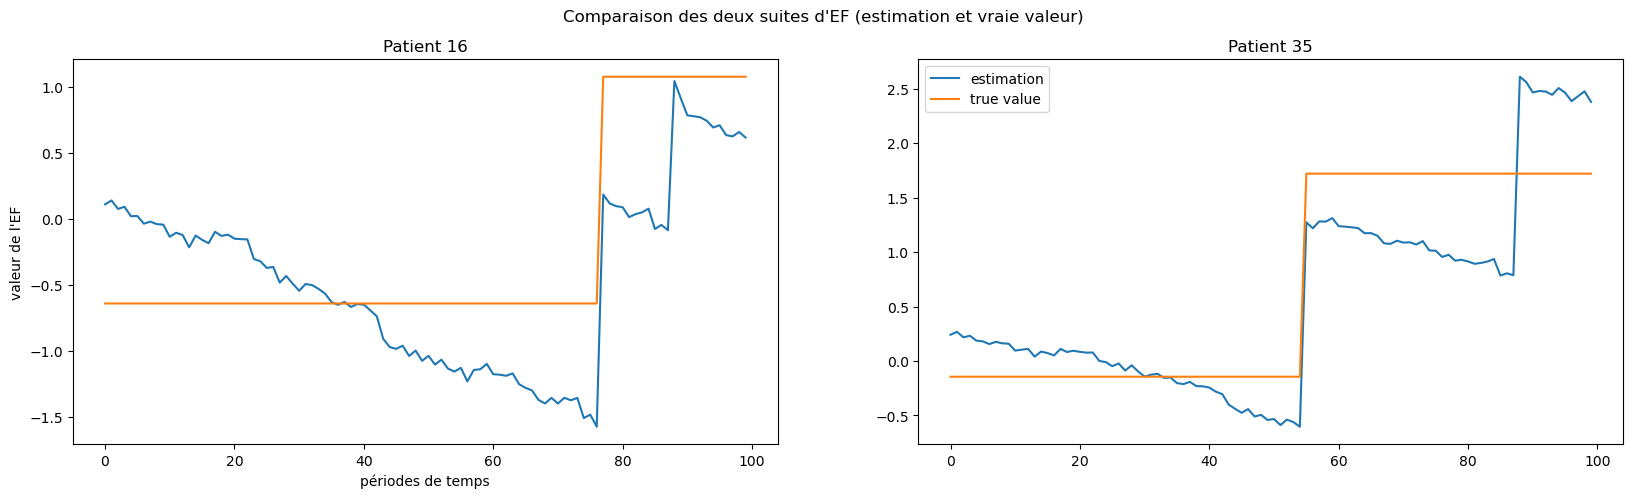

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Comparaison des deux suites d'EF (estimation et vraie valeur)")
ax1.plot(estimates['estimates']['cost']['alpha'][13], label = 'estimation')
ax1.plot(estimates['true_value']['cost']['alpha'][13], label = 'true value')
ax1.set_xlabel('périodes de temps')
ax1.set_ylabel("valeur de l'EF")
ax1.title.set_text('Patient 16')
ax2.plot(estimates['estimates']['cost']['alpha'][23], label = 'estimation')
ax2.plot(estimates['true_value']['cost']['alpha'][23], label = 'true value')
ax2.title.set_text('Patient 35')
plt.legend()

In [3]:
%%capture
start_time = time.time()
simulation_bad = temporal_simulation(nb_of_periods=60,
                                    n_patients=100,
                                    n_doctors=100,
                                    z=0.4,
                                    alpha_law_graph=(-1, 0),
                                    psi_law_graph=(-1, 0),
                                    alpha_law_cost=(-1, 0),
                                    psi_law_cost=(-1, 0),
                                    preconditioner = 'jacobi',
                                    beta_age_p_graph=0.01,
                                    beta_age_d_graph=0.01,
                                    beta_sex_p_graph=0.5,
                                    beta_sex_d_graph=0.5,
                                    beta_distance_graph=-0.5,
                                    beta_age_p_cost=0.01,
                                    beta_age_d_cost=0.01,
                                    beta_sex_p_cost=0.5,
                                    beta_sex_d_cost=0.5,
                                    beta_distance_cost=0.5)
end_time = time.time()

simulation_good = temporal_simulation(nb_of_periods=60,
                                    n_patients=400,
                                    n_doctors=100,
                                    z=1.1,
                                    alpha_law_graph=(-1, 0),
                                    psi_law_graph=(-1, 0),
                                    alpha_law_cost=(-1, 0),
                                    psi_law_cost=(-1, 0),
                                    preconditioner = 'jacobi',
                                    beta_age_p_graph=0.01,
                                    beta_age_d_graph=0.01,
                                    beta_sex_p_graph=0.5,
                                    beta_sex_d_graph=0.5,
                                    beta_distance_graph=-0.5,
                                    beta_age_p_cost=0.01,
                                    beta_age_d_cost=0.01,
                                    beta_sex_p_cost=0.5,
                                    beta_sex_d_cost=0.5,
                                    beta_distance_cost=0.5)

In [4]:
estimates_bad = extract(simulation_bad)
estimates_good = extract(simulation_good)

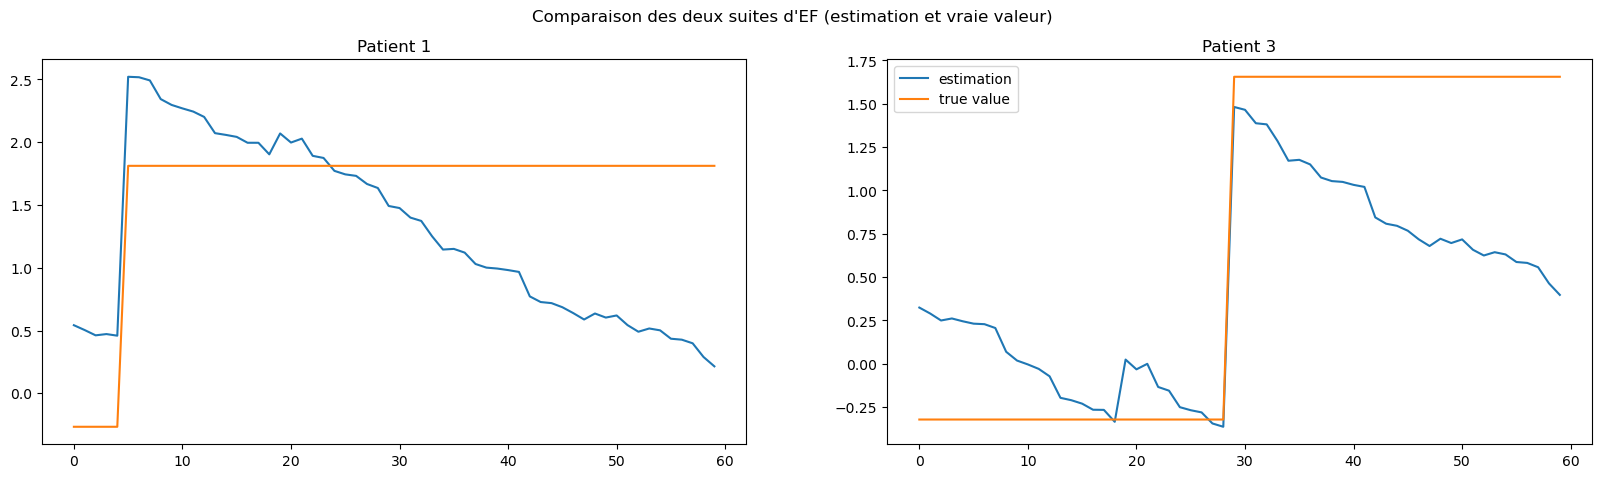

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Comparaison des deux suites d'EF (estimation et vraie valeur)")
ax1.plot(estimates_bad['estimates']['cost']['alpha'][32], label = 'estimation')
ax1.plot(estimates_bad['true_value']['cost']['alpha'][32], label = 'true value')
ax1.title.set_text('Patient 1')
ax2.plot(estimates_bad['estimates']['cost']['alpha'][35], label = 'estimation')
ax2.plot(estimates_bad['true_value']['cost']['alpha'][35], label = 'true value')
ax2.title.set_text('Patient 3')
plt.legend()

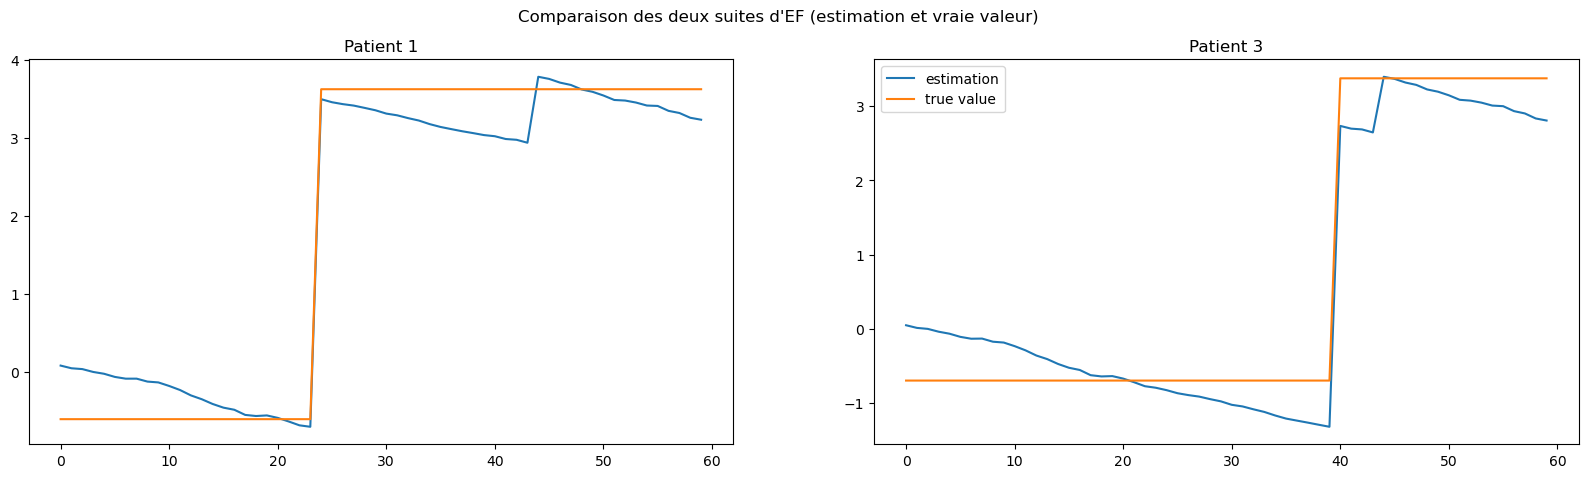

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Comparaison des deux suites d'EF (estimation et vraie valeur)")
ax1.plot(estimates_good['estimates']['cost']['alpha'][12], label = 'estimation')
ax1.plot(estimates_good['true_value']['cost']['alpha'][12], label = 'true value')
ax1.title.set_text('Patient 1')
ax2.plot(estimates_good['estimates']['cost']['alpha'][23], label = 'estimation')
ax2.plot(estimates_good['true_value']['cost']['alpha'][23], label = 'true value')
ax2.title.set_text('Patient 3')
plt.legend()

In [ ]:
# FAIRE LES POTS DES DEUX ESTIMATIONS CI-DESSUS, J'AI DEJA DES SIMULATIONS QUI MONTRENT QUE DEUX SUITES D'ESTIMATEURS PEUVENT RENDRE LA DETECTION DES POINTS DE RUPTURE DIFFICILES SELON LA QUALITE
# DES ESTIMATIONS, MAIS PEUT-ÊTRE QU'ICI CE SERA VRAIMENT MARQUE ?

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Comparaison des deux suites d'EF (estimation et vraie valeur)")
ax1.plot(estimates['estimates']['cost']['alpha'][31], label = 'estimation')
ax1.plot(estimates['true_value']['cost']['alpha'][31], label = 'true value')
ax1.title.set_text('Patient 1')
ax2.plot(estimates['estimates']['cost']['alpha'][34], label = 'estimation')
ax2.plot(estimates['true_value']['cost']['alpha'][34], label = 'true value')
ax2.title.set_text('Patient 3')
plt.legend()

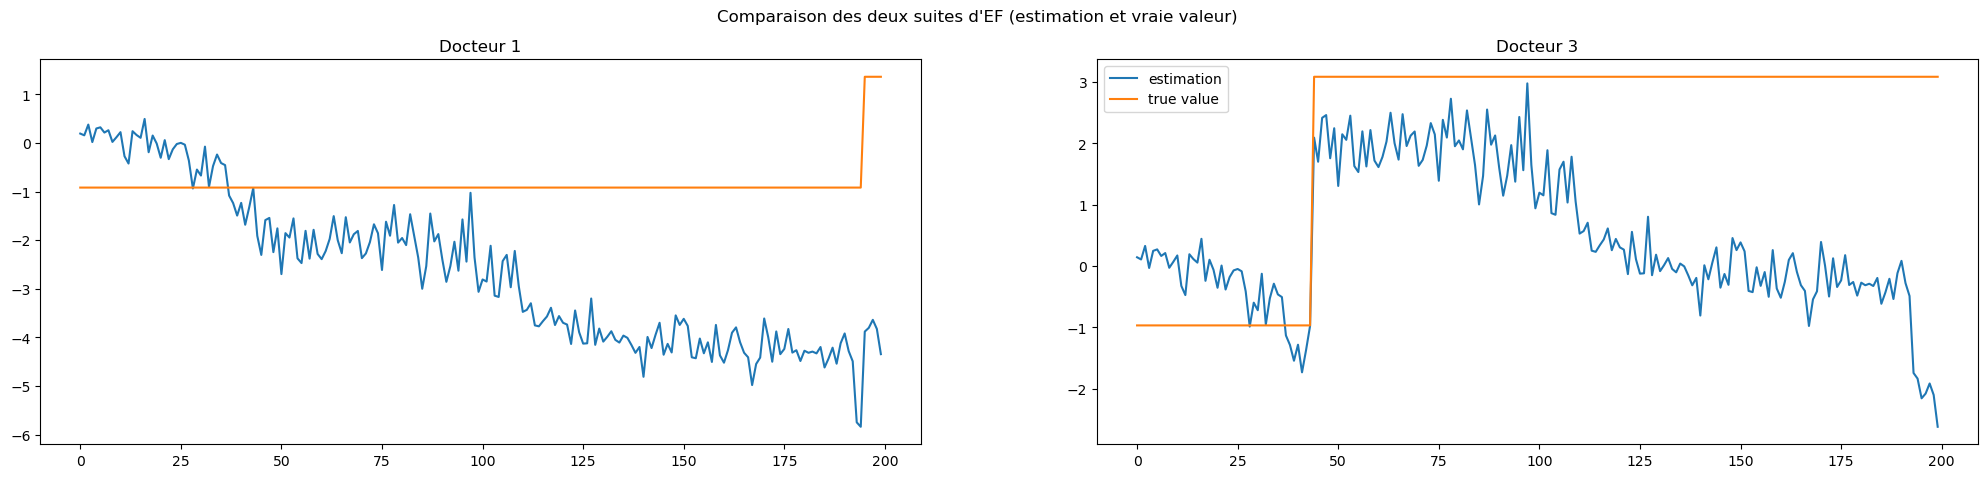

In [756]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Comparaison des deux suites d'EF (estimation et vraie valeur)")
ax1.plot(estimates['estimates']['psi'][4], label = 'estimation')
ax1.plot(estimates['true_value']['psi'][4], label = 'true value')
ax1.title.set_text('Docteur 1')
ax2.plot(estimates['estimates']['psi'][5], label = 'estimation')
ax2.plot(estimates['true_value']['psi'][5], label = 'true value')
ax2.title.set_text('Docteur 3')
plt.legend()

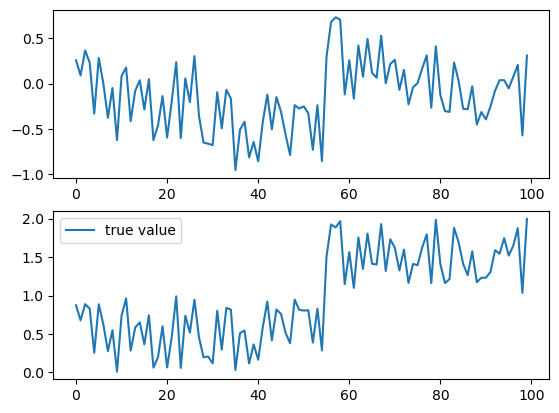

In [10]:
figure, axis = plt.subplots(2)
axis[0].plot(estimates['estimates']['alpha'][20])
axis[1].plot(estimates['true_value']['alpha'][20], label = 'true value')
plt.legend()
plt.show()

In [458]:

[[chngpts['true_value']['alpha'][i], chngpts['estimates']['alpha'][i]] for i in range(len(chngpts['estimates']['alpha']))]
# chngpts['true_value']['psi'][i], chngpts['estimates']['psi'][i]

[[20, 20],
 [95, 95],
 [175, 175],
 [145, 145],
 [145, 145],
 [110, 110],
 [170, 170],
 [180, 180],
 [45, 45],
 [165, 165],
 [145, 145],
 [105, 105],
 [35, 35],
 [60, 60],
 [180, 180],
 [155, 160],
 [165, 165],
 [10, 10],
 [110, 110],
 [50, 50],
 [75, 75],
 [25, 25],
 [150, 150],
 [35, 35],
 [120, 120],
 [70, 65],
 [70, 70],
 [80, 80],
 [40, 40],
 [185, 40],
 [120, 120],
 [35, 35],
 [45, 45],
 [55, 55],
 [10, 10],
 [70, 70],
 [40, 40],
 [185, 185],
 [10, 10],
 [60, 60],
 [145, 35],
 [125, 125],
 [75, 75],
 [150, 150],
 [55, 55],
 [40, 40],
 [15, 15],
 [140, 140],
 [30, 40],
 [30, 30],
 [10, 10],
 [115, 115],
 [170, 170],
 [10, 10],
 [180, 180],
 [25, 25],
 [175, 65],
 [25, 25],
 [10, 10],
 [130, 130],
 [180, 180],
 [35, 35],
 [80, 80],
 [65, 65],
 [90, 90],
 [115, 115],
 [115, 55],
 [20, 20],
 [130, 130],
 [135, 135],
 [180, 180],
 [185, 185],
 [120, 120],
 [35, 35],
 [30, 30],
 [185, 185],
 [170, 170],
 [60, 60],
 [100, 100],
 [185, 185],
 [180, 180],
 [120, 120],
 [30, 30],
 [125, 12

In [471]:
[[chngpts['true_value']['psi'][j], chngpts['estimates']['psi'][j]] for j in range(len(chngpts['estimates']['psi']))]

[[35, 200],
 [35, 120],
 [40, 35],
 [85, 85],
 [115, 115],
 [185, 185],
 [30, 40],
 [175, 175],
 [20, 55],
 [185, 40]]

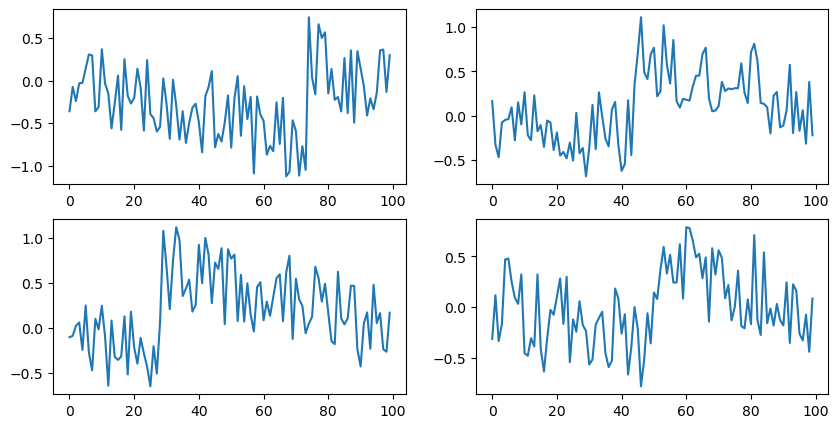

In [54]:
figure, axis = plt.subplots(2, 2, figsize=(10, 5))
axis[0, 0].plot(estimates['estimates']['cost']['alpha'][20])
axis[0, 1].plot(estimates['estimates']['cost']['alpha'][5])
axis[1, 0].plot(estimates['estimates']['cost']['alpha'][88])
axis[1, 1].plot(estimates['estimates']['cost']['alpha'][46])

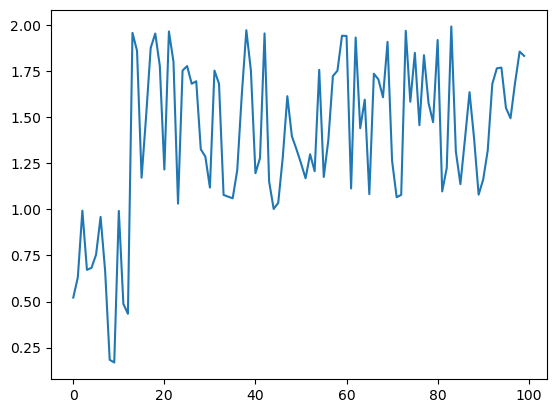

In [62]:
plt.plot(pd.DataFrame(estimates['true_value']['cost']['alpha'][10]))

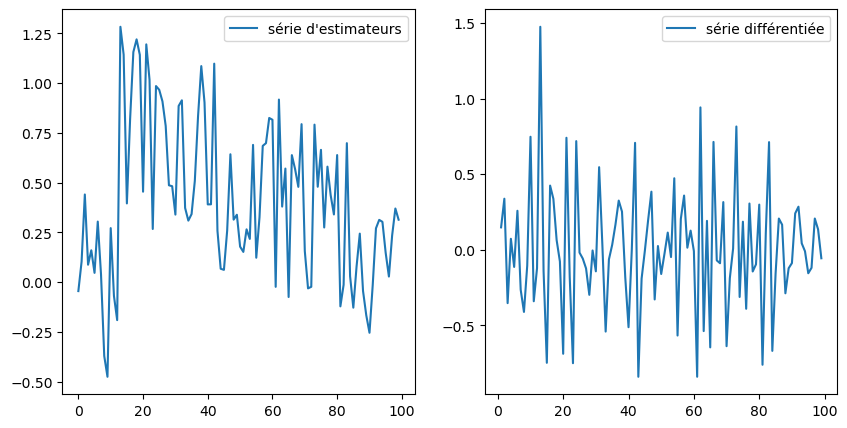

In [55]:
test = pd.DataFrame(estimates['estimates']['cost']['alpha'][10])
test2 = pd.DataFrame(estimates['true_value']['cost']['alpha'][10])
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(test, label = "série d'estimateurs")
axis[0].legend()
axis[1].plot(test.diff().values, label = 'série différentiée')
axis[1].legend()

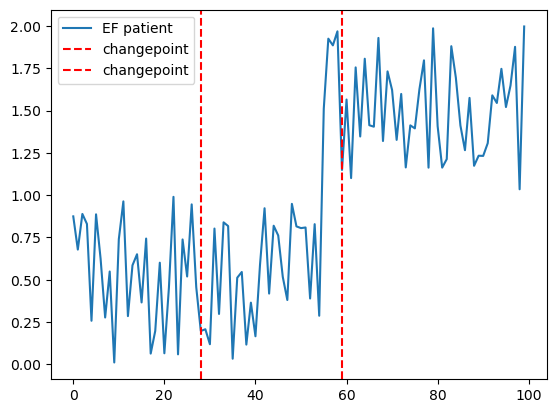

In [16]:
plt.plot(estimates['true_value']['cost']['alpha'][20], label = 'EF patient')
plt.axvline(28, color = 'red', linestyle = 'dashed', label = "changepoint")
plt.axvline(59, color = 'red', linestyle = 'dashed', label = "changepoint")
plt.legend()
plt.show()

In [ ]:
%%capture 
alpha_law = (0, 0.5)
psi_law = (0, 0.5)
model = simTest.SimBipartiteTest(
    simTest.sim_params(
    {
        'n_patients' : 150,
        'n_doctors' : 10,
        'alpha_law': alpha_law,
        'psi_law': psi_law,
        'beta_1': 0.001,
        'beta_2': 0.001,
        'beta_3': 0.01,
        'beta_4': 0.01,
        'beta_5': -0.5,
        'z': 0.2,
    }
    )
)
df = model.simulate()
distance_matrix = model.D # We need to simulate first so the matrix D is generated
simulation = temporal_simulation(df,
                                 distance_matrix,
                                 200,
                                 (0, 0.5),
                                 psi_law=(0, 0.5),
                                 # preconditioner='jacobi',
                                 beta_age_p=0.5,
                                 beta_age_d=0.5,
                                 beta_sex_p=0.5,
                                 beta_sex_d=0.5,
                                 beta_distance=0.5
                        
                          )

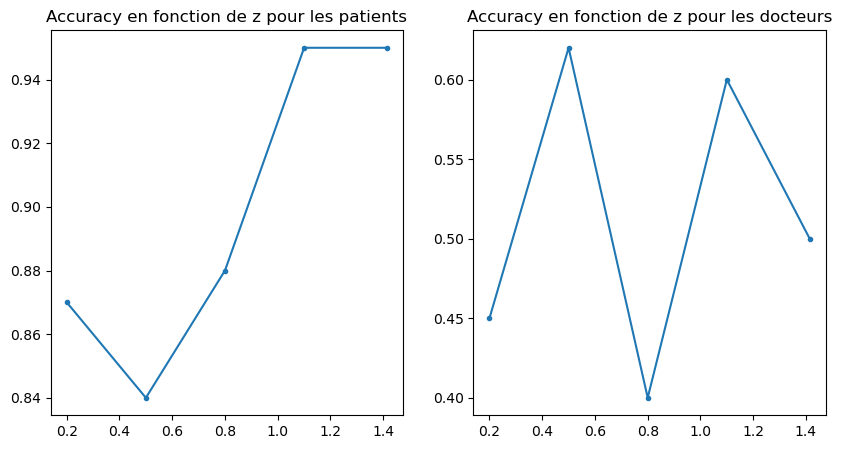

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot([0.2, 0.5, 0.8, 1.1, np.sqrt(2)], [0.87, 0.84, 0.88, 0.95, 0.95], marker= '.')
ax1.title.set_text('Accuracy en fonction de z pour les patients')
ax2.plot([0.2, 0.5, 0.8, 1.1, np.sqrt(2)], [0.45, 0.62 , 0.4, 0.6, 0.5], marker= '.')
ax2.title.set_text('Accuracy en fonction de z pour les docteurs')

In [16]:
%%capture
res1= aggreg_rmse(100, dist=0.4)

In [17]:
%%capture
res2= aggreg_rmse(100, dist=0.6)

In [18]:
%%capture
res3= aggreg_rmse(100, dist=0.8)

In [19]:
%%capture
res4= aggreg_rmse(100, dist=1)

In [20]:
%%capture
res5= aggreg_rmse(100, dist=1.2)

In [47]:
%%capture
res6= aggreg_rmse(30, dist=np.sqrt(2))

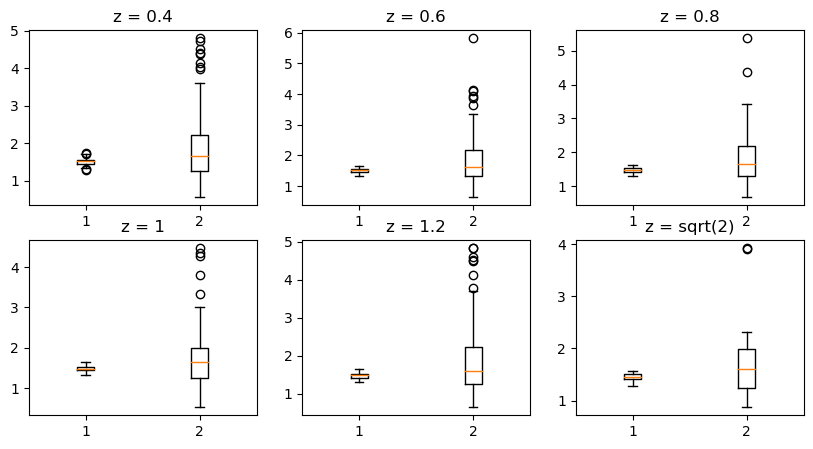

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes[0][0].boxplot(res1)
axes[0][0].title.set_text("z = 0.4")
axes[0][1].boxplot(res2)
axes[0][1].title.set_text("z = 0.6")
axes[0][2].boxplot(res3)
axes[0][2].title.set_text("z = 0.8")
axes[1][0].boxplot(res4)
axes[1][0].title.set_text("z = 1")
axes[1][1].boxplot(res5)
axes[1][1].title.set_text("z = 1.2")
axes[1][2].boxplot(res6)
axes[1][2].title.set_text("z = sqrt(2)")

In [78]:
mean_rmse_patient = [np.array(res1[0]).mean(),
             np.array(res2[0]).mean(),
             np.array(res3[0]).mean(),
             np.array(res4[0]).mean(),
             np.array(res5[0]).mean(),
             np.array(res6[0]).mean()]

mean_rmse_docteurs = [np.array(res1[1]).mean(),
                      np.array(res2[1]).mean(),
                      np.array(res3[1]).mean(),
                      np.array(res4[1]).mean(),
                      np.array(res5[1]).mean(),
                      np.array(res6[1]).mean()]

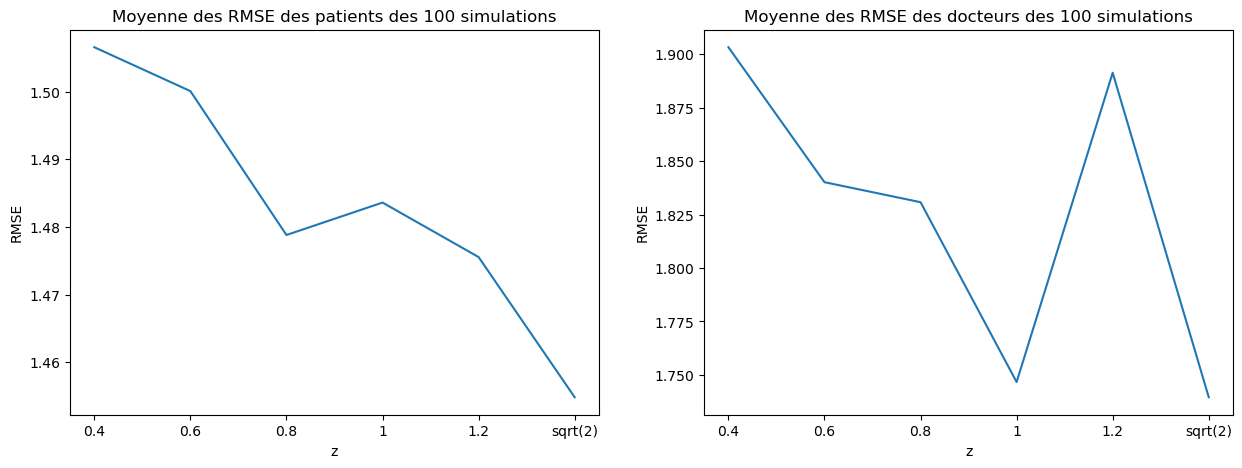

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot([0.4, 0.6, 0.8, 1, 1.2, "sqrt(2)"], mean_rmse_patient)
axes[0].set_xlabel("z")
axes[0].set_ylabel("RMSE")
axes[0].title.set_text("Moyenne des RMSE des patients des 100 simulations")
axes[1].plot([0.4, 0.6, 0.8, 1, 1.2, "sqrt(2)"], mean_rmse_docteurs)
axes[1].set_xlabel("z")
axes[1].set_ylabel("RMSE")
axes[1].title.set_text("Moyenne des RMSE des docteurs des 100 simulations")